# Retinal OCT Imaging
<hr style="border:2px solid pink">

## Introduction

#### Background

Retinal optical coherence tomography (OCT) is a noninvasive imaging technique that essentially takes pictures of your retinas by measuring how much light reflects off the retina and optic nerve. It can be used to diagnose and manage diseases like diabetes-related retinopathy and glaucoma, amongst others. Millions of OCT scans are performed each year, and the analysis and interpretation of the images can take up a tremendous amount of time.

#### Business Problem

In order to save time and resources in analyzing and interpreting OCT scans, the problem at hand is to create a model that can predict whether a patient's retinal scan is normal or shows signs of CNV, DME, or DRUSEN diseases. 

The stakeholders are medical professionals, specifically ophthalmologists.

#### Data Understanding

The data for this project comes from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/kermany2018/data. It
contains 84,495 images, and 4 categories to predict (NORMAL, CNV, DME, or DRUSEN). 

The data is split into separate train, test, and validation folders. Within each of these, there are labeled sub-folders for each category, with each individual image labeled as such: (disease)-(randomized patient ID)-(image number by
this patient).

The images were selected from adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017. 

#### Definitions

According to the National Library of Medicine, the following terms are defined as follows: 

1. CNV: (Choroidal Neovascularization): a condition where abnormal blood vessels grow beneath the retina in the choroid area. These abnormal blood vessels can leak fluid or blood into the retina, which can cause vision loss. Commonly associated with age-related macular degeneration (AMD), which is a leading cause of vision loss in older adults.

2. DME (Diabetic Macular Edema): a complication of diabetic retinopathy, which is an eye condition that can develop in people with diabetes. DME occurs when fluid builds in the macula, the central part of the retina responsible for our central vision, leading to to vision impairment and distortion.

3. Drusen: small yellow or white deposits that accumulate in the retina. They can be found in the macula or the peripheral retina. Drusen are a hallmark sign of age-related macular degeneration (AMD). 

Treatment options for CNV, DME, and AMD may include medications, laser therapy, or in some cases, surgical interventions, depending on the specific condition and its stage.
<hr style="border:2px solid pink">

# General Exploration

Before we start the modeling process, let's get an idea of the data we're working with. To get started, let's import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.image import imread
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, StratifiedKFold

from sklearn.metrics import confusion_matrix, classification_report, make_scorer,\
recall_score,accuracy_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, TruePositives, TrueNegatives, FalseNegatives, FalsePositives

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

Let's load in the data next. We need to create directories to where the data is saved, so let's start with that. 

In [2]:
# create directory paths for each folder (train, test, and val)
train_path = '../Data/OCT2017/train'
test_path = '../Data/OCT2017/test'
val_path = '../Data/OCT2017/val'

To investigate the raw data, I'll load it in normally, i.e., no scaling or augmentations done, using ImageDataGenerator() from tensorflow Keras. I'll set smaller batch sizes to help with efficiency, and I'll set the seed to 42 to help with reproducibility. 

In [3]:
original_train = ImageDataGenerator().flow_from_directory(train_path, batch_size=200, seed=42)
original_test = ImageDataGenerator().flow_from_directory(test_path, batch_size=100, seed=42)
original_val = ImageDataGenerator().flow_from_directory(val_path, batch_size=5, seed=42)

original_train_images, original_train_labels = next(original_train)
original_test_images, original_test_labels = next(original_test)
original_val_images, original_val_labels = next(original_val)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Notice that there are 4 classes: This represents normal, CNV, DME, or Drusen. Before visualizing the distribution, let's find out the original size of the images. First, I will look at the shape of each dataset to get a general idea. Then, to make sure each image is the same size, I will loop through every image in the images dataset, take its size, add it to a list, and take the unique values of that list. 

In [4]:
# look at the shapes
print(f"Train Images Shape: {original_train_images.shape}")
print(f"Train Labels Shape: {original_train_labels.shape}")
print(f"Test Images Shape: {original_test_images.shape}")
print(f"Test Labels Shape: {original_test_labels.shape}")
print(f"Val Images Shape: {original_val_images.shape}")
print(f"Val Labels Shape: {original_val_labels.shape}")

Train Images Shape: (200, 256, 256, 3)
Train Labels Shape: (200, 4)
Test Images Shape: (100, 256, 256, 3)
Test Labels Shape: (100, 4)
Val Images Shape: (5, 256, 256, 3)
Val Labels Shape: (5, 4)


It looks like each image is 256x256, but let's confirm this with the loop.

In [5]:
# loop through each images in the array and add the size to an empty list
train_sizes = []
test_sizes = []
val_sizes = []

for img in original_train_images:
    size = np.array(array_to_img(img).size)
    train_sizes.append(size)
    
for img in original_test_images:
    size = np.array(array_to_img(img).size)
    test_sizes.append(size)
    
for img in original_val_images:
    size = np.array(array_to_img(img).size)
    val_sizes.append(size)

In [6]:
# how many unique sizes are in each list? theoretically should be the same for each pic
# change the list of np arrays into a list of tuples, then take the "set" to get unique values

unique_train_sizes = list(set([tuple(size) for size in train_sizes]))
unique_test_sizes = list(set([tuple(size) for size in test_sizes]))
unique_val_sizes = list(set([tuple(size) for size in val_sizes]))

print(f"Original Train Image Size: {unique_train_sizes}")
print(f"Original Test Image Size: {unique_test_sizes}")
print(f"Original Val Image Size: {unique_val_sizes}")

Original Train Image Size: [(256, 256)]
Original Test Image Size: [(256, 256)]
Original Val Image Size: [(256, 256)]


Great! So the original images were indeed all 256x256. Since I noticed when loading in the data that there are 4 classes, let's now take a look at the distribution of the images in our dataset. 

In [7]:
# first, create paths to each individual folder
normal_train_path = '../Data/OCT2017/train/NORMAL'
cnv_train_path = '../Data/OCT2017/train/CNV'
dme_train_path = '../Data/OCT2017/train/DME'
drusen_train_path = '../Data/OCT2017/train/DRUSEN'

# then, take the "length" of each folder to get the total number of images per category
normal_count = len(os.listdir(normal_train_path))
cnv_count = len(os.listdir(cnv_train_path))
dme_count = len(os.listdir(dme_train_path))
drusen_count = len(os.listdir(drusen_train_path))

# print the results
print(f'Normal Count: {normal_count}')
print(f'CNV Count: {cnv_count}')
print(f'DME Count: {dme_count}')
print(f'Drusen Count: {drusen_count}')

Normal Count: 26315
CNV Count: 37205
DME Count: 11348
Drusen Count: 8616


So, there are 26,315 normal images, 37,205 CNV images, 11,348 DME images, and 8,616 Drusen images. Notices that this is imbalanced - there are many more CNV and normal images than there are DME and Drusen. Let's visualize the distribution. 

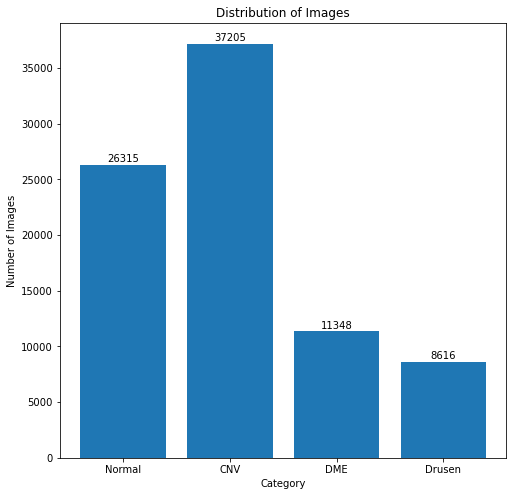

In [8]:
# create the categories for X (categories) and Y (counts)
categories = ['Normal', 'CNV', 'DME', 'Drusen']
counts = [normal_count, cnv_count, dme_count, drusen_count]

# plot it
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images')

# add counts to the top of the bars
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show();

This makes the distributions a little more clear! There's the most CNV images and the least Drusen images. Another thing to note is that since our dataset it imbalanced, it may be beneficial to try data augmentation when modeling to help produce more samples of each class. 

Let's look at a few images and labels, so we can get an idea of what we're dealing with. 

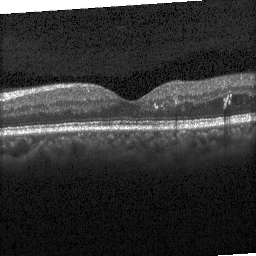

In [9]:
array_to_img(original_train_images[16])

In [10]:
original_train_labels[16]

array([0., 1., 0., 0.], dtype=float32)

In [11]:
original_train.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

Ok, so here, I see that each category corresponds to a class. CNV is class 0, DME is class 1, DRUSEN is class 2, and NORMAL is class 3. 

You would interpret the array [0., 1., 0., 0.] as follows: the first class (index 0, corresponds to CNV) has a probability of 0. The second class (index 1, corresponds to DME) has a probability of 1. The third class (index 2, corresponds to Drusen) and the fourth class (index 3, corresponds to normal) have probabilities of 0. This means that the image falls under class 1, and is DME. 

Let's plot a few images from each class, with their corresponding labels titling the plot.

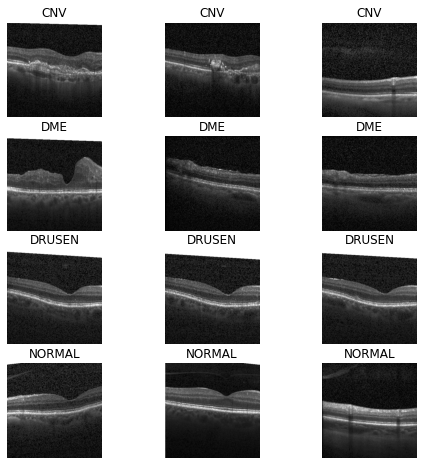

In [12]:
# we have paths to each subfolder, so create a list paths that has them all
# create a list categories with each of the subfolders for labeling purposes
paths = [cnv_train_path, dme_train_path, drusen_train_path, normal_train_path]
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
fig, axes = plt.subplots(nrows=len(categories), ncols=3, figsize=(8, 8))

# iterate through paths to get the image path
for index, path in enumerate(paths):
    image_files = [file for file in os.listdir(path) if file.endswith('.jpeg')]
    
    # Limit the number of images to fit the layout
    total_images_per_cat = min(len(image_files), 3)
    
    for i in range(total_images_per_cat): 
        image_file = image_files[i]
        image_path = os.path.join(path, image_file)
        image = imread(image_path)
        image = image[:400, :400]
            
        # Display the image in a subplot
        ax = axes[index, i]
        ax.imshow(image, cmap='gray')
        ax.set_title(categories[index])  # Display the label
        ax.axis('off')

plt.show()

Great! So we have a little better understanding of what each image might look like. Let's start preprocessing so we can start modeling. 

# Preprocessing

To preprocess the data for a convolutional neural network, I will start the following: 
1. Scale the data: CNNs are sensitive to the scale of input features. Scaling the data will ensure numerical stability during training. For images, pixel values are usually in the range [0,255], so to rescale them to the range [0,1], I will divide each pixel by 255.
2. Resize the images: Smaller images can be less computationally intensive, leading to faster training times. This will also help ensure all inputs have the same shape. I will start with decreasing the size to 64x64.
3. Set the seed: To help with reproducibility, I will set the seed equal to 42. 
4. Set the color mode: Since these images are originally in black and white, I will set the color_mode to grayscale to capture this. 
5. Set data augmentation filters: I'll add filters such as flipping, shifting, rotating, and adjusting the brightness/zoom/shearness of the images. This will randomly apply these transformations to the images in order to add more data to the training set only, adding variety into my model and increasing the size of the training set. This should help with generalization. 
6. Set to binary: **ADD WHY**

In [13]:
# load in and preprocess the data in smaller batches
# Scale and transform the images, reshape to be 64x64, set the seed, and set the color to grayscale

target_size = (64,64)
train_generator = ImageDataGenerator(rescale=1.0/255.0, 
                                     horizontal_flip=True,
                                     height_shift_range=0.2,
                                     width_shift_range=0.2,
                                     rotation_range=45,
                                     brightness_range=[0.4,1],
                                     zoom_range=0.2, 
                                     shear_range=0.2
                                     ).flow_from_directory(train_path, 
                                                           target_size=target_size, 
                                                           batch_size=500, 
                                                           seed=42, 
                                                           color_mode='grayscale', 
                                                           class_mode='binary') 

test_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(test_path, 
                                                                         target_size=target_size, 
                                                                         batch_size=100, 
                                                                         seed=42, 
                                                                         color_mode='grayscale', 
                                                                         class_mode='binary')

val_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(val_path, 
                                                                        target_size=target_size, 
                                                                        batch_size=5, 
                                                                        seed=42, 
                                                                        color_mode='grayscale', 
                                                                        class_mode='binary')

# next fetches the next batch of data and labels from the generator
# returns a batch of images and their labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Great! Let's check out the following to make sure everything was properly loaded. 
1. Check out the shapes - everything should be rescaled to 64x64. 
2. Check out the images - everything should be in black and white and smaller in size. 

In [14]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"Val Images Shape: {val_images.shape}")
print(f"Val Labels Shape: {val_labels.shape}")

Train Images Shape: (500, 64, 64, 1)
Train Labels Shape: (500,)
Test Images Shape: (100, 64, 64, 1)
Test Labels Shape: (100,)
Val Images Shape: (5, 64, 64, 1)
Val Labels Shape: (5,)


The shapes all look good! We can see that they are indeed 64x64 for the images, with the color channel as 1, indicating it is grayscale. Next, let's check out a few images. 

In [15]:
train_generator.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

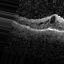

In [16]:
array_to_img(train_images[0])

In [17]:
# returning 1, meaning the corresponding image is labeled as DME (index 1)
print(train_labels[0])

1.0


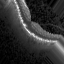

In [18]:
array_to_img(train_images[3])

In [19]:
# returning 3, meaning the corresponding image is labeled as normal (index 3)
print(train_labels[3])

3.0


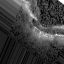

In [20]:
array_to_img(train_images[6])

In [21]:
# returning 0, meaning the corresponding image is labeled as CNV (index 0)
print(train_labels[6])

0.0


The images look good, they are in black and white, and scaled down to 64x64. 

Here, I'd like to point out that this is a multiclass classification task. There are several notebooks exploring building mutliclass models, please refer to them for more details on multiclass. You can find them in the code folder. 

For this notebook, I will explore a binary classification: are the images normal, or are they abnormal (where abnormal is any CNV, DME, or Drusen images). 

# Creating Binary Labels

Here, I'd like to change the labels from multiclass (4 classes) to binary class (2 classes). This approach has both limitations and advantages; we lose the individuality between the different diseases, but we gain increased accuracy at identifying diseased vs normal images.  

I will group any image that is CNV, DME, and Drusen under "abnormal", and any image that is normal under "normal". Since the model will always try to predict class 1, it's important to consider the business problem and the overall goal of the model before assigning classes. 

My goal here is to catch abnormalities. It is better to flag an image as abnormal and have the patient come in for another scan than to flag an image as normal when there was actually a disease present. So, it would make sense to have abnormalities as class 1 and normal as class 0. 

I will also prioritize recall - high recall in medical diagnostics means the model is effectively identifying most of the actual abnormalities, which reduces false negatives. This is vital in reducing the number of missed diagnoses. 

First, let's check out the distribution of normal vs abnormal images. 

In [22]:
# check the distribution
abnormal_count = cnv_count + dme_count + drusen_count
print(f'Total Abnormal: {abnormal_count}')
print(f'% Abnormal: {round(abnormal_count/(abnormal_count + normal_count),2)}')
print('------------------------')
print(f'Total Normal: {normal_count}')
print(f'% Normal: {round(normal_count/(abnormal_count + normal_count),2)}')

Total Abnormal: 57169
% Abnormal: 0.68
------------------------
Total Normal: 26315
% Normal: 0.32


I see here that 68% of the data is abnormal, and 32% of the data is normal. This means my model might try and predict the majority class every time, and be 68% accurate at it. I will, in some of the later models, adjust the class weights to counter this. In the meantime, I will be cautious of high accuracy scores. 

Now, let's change the labels. First, let me remind myself what the current classes are so I can make sure I correctly change them. 

In [23]:
train_generator.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

Great. To change the labels, I will simply replace any value with index 3 (corresponding to normal) with a 0 (to correspond to class 0), and anything else with a 1 (so CNV, DME, and Drusen, or the abnormalities, will be class 1). 

In [24]:
# change for train, test, and val
# np.where changes the values so that anything index 3 is turned into 0 and everything else is a 1
binary_train_labels = np.where(train_labels == 3, 0, 1)
binary_test_labels = np.where(test_labels == 3, 0, 1)
binary_val_labels = np.where(val_labels == 3, 0, 1)

To confirm it worked, I will look at a few images and their new vs old labels to make sure they line up. 

Let's look at a normal image first. The old label should have index 3 marked, and the new labels should be class 0. 

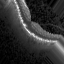

In [25]:
array_to_img(train_images[3])

In [26]:
# original label
# returning 3, so this is normal. should be class 0 in binary
print(train_labels[3])

3.0


In [27]:
print(binary_train_labels[3])

0


Great! Let's do the same for DME. Should be class 1 in binary. 

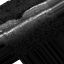

In [28]:
array_to_img(train_images[16])

In [29]:
# original label
# returning 1, so this is dme. should be class 1 in binary
print(train_labels[16])

1.0


In [30]:
print(binary_train_labels[16])

1


Great! Next up is CNV, should be class 1 in binary. 

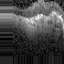

In [31]:
array_to_img(train_images[1])

In [32]:
# original label
# returning 0, so this is cnv. should be class 1 in binary
print(train_labels[1])

0.0


In [33]:
print(binary_train_labels[1])

1


Finally, let's look at Drusen, should also be class 1 in binary. 

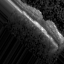

In [34]:
array_to_img(train_images[87])

In [35]:
# original label
# returning 2, so this is drusen. should be class 1 in binary
print(train_labels[88])

2.0


In [36]:
print(binary_train_labels[88])

1


Great! It looks like the labels are correctly updated. I'll use these moving forward. 

Next, let's build some functions to help with the modeling process. 

# Creating Functions

I will build the following functions to help speed up viewing the results of each model. 
1. A function that evaluates the model's train and test performance. 
2. A function to plot the loss and accuracy. 
3. A function to plot the confusion matrices. 

Let's start with the evaluate function. We'll print out the loss, accuracy, precision, and recall for both the train and test sets. 

In [37]:
# 1. a function that evaluates the train and test performance of the model
def evaluate_model(model):
    train_results = model.evaluate(train_images, binary_train_labels)
    test_results = model.evaluate(test_images, binary_test_labels)
    
    print('---------------------------')
    print(f'Training Loss: {train_results[0]:.3}')
    print(f'Training Accuracy: {train_results[1]:.3}')
    print(f'Training Precision: {train_results[2]:.3}')
    print(f'Training Recall: {train_results[3]:.3}')
#     print(f'Training True Positives: {train_results[4]}')
#     print(f'Training True Negatives: {train_results[5]}')
#     print(f'Training False Positives: {train_results[6]}')
#     print(f'Training False Negatives: {train_results[7]}')
          
    print('---------------------------')
    print(f'Testing Loss: {test_results[0]:.3}')
    print(f'Testing Accuracy: {test_results[1]:.3}')
    print(f'Testing Precision: {test_results[2]:.3}')
    print(f'Testing Recall: {test_results[3]:.3}')
#     print(f'Testing True Positives: {test_results[4]}')
#     print(f'Testing True Negatives: {test_results[5]}')
#     print(f'Testing False Positives: {test_results[6]}')
#     print(f'Testing False Negatives: {test_results[7]}')    

Next, I'll create a function to plot the loss and accuracy for each model. 

In [38]:
# 2. a function to plot the loss and accuracy
def plot_metrics(results):
    train_loss = results.history['loss']
    train_accuracy = results.history['accuracy']

    val_loss = results.history['val_loss']
    val_accuracy = results.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label='train_accuracy')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='val_accuracy')
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show();

Finally, let's create a function to plot the confusion matrix for us.

confusion matrix only plotting for individual batches, can't get it for the test set AFTER the train test split

In [39]:
# 3. a function to plot the confusion matrix
def plot_confusion_matrix(model, test_images, binary_test_labels):
    Y_pred = model.predict(test_images)
    y_pred = np.argmax(Y_pred, axis=1)
    y_test = np.argmax(y_pred)

    cm = confusion_matrix(binary_test_labels, y_pred)
    cm_df = pd.DataFrame(cm, index=['ABNORMAL', 'NORMAL'], columns=['ABNORMAL', 'NORMAL'])

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True, cmap='plasma')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

# Baseline model

For my baseline model, I will use the class distribution. Let's compare abnormal (CNV, DRUSEN, DME) and normal.

In [40]:
abnormal_count = cnv_count + dme_count + drusen_count
print(f'Total Abnormal: {abnormal_count}')
print(f'% Abnormal: {round(abnormal_count/(abnormal_count + normal_count),2)}')
print('------------------------')
print(f'Total Normal: {normal_count}')
print(f'% Normal: {round(normal_count/(abnormal_count + normal_count),2)}')

Total Abnormal: 57169
% Abnormal: 0.68
------------------------
Total Normal: 26315
% Normal: 0.32


So 68% abnormal, 32% normal. This means that, if you were to predict just the majority class every time (which in this case is having an abnormality), the model would be accurate 68% of the time. This is the accuracy that we need to beat!

Let's get started with the modeling!

# First Simple Model

For my first simple model, I will use a simple convolutional neural network with no hidden convolutional layers. I will begin with a dense input layer, expecting grayscale images of size 64x64x1. The input layer will have 64 units and use the ReLU activation function to introduce non-linearity and capture complex features. Next, I will add a flatten layer to transform the output from the previous layer into a 1D vector, preparing it for the final output layer. The output layer will consist of a dense layer with 1 units to represent the binary classes, and it will use the sigmoid activation function, which is a common choice for binary classification tasks.

In [41]:
# set the variable input_shape to save time/avoid typos throughout modeling
input_shape = (64, 64, 1)

In [42]:
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=input_shape))
model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

Let's view the architecture of the model. 

In [43]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64, 64, 64)        128       
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 262145    
Total params: 262,273
Trainable params: 262,273
Non-trainable params: 0
_________________________________________________________________


So we can see that there are a 262,273 parameters. Let's compile the model using the adam optimizer (Adam is a good starting choice because Adam is an adaptive learning rate optimization algorithm. It should help with a more efficient convergence), binary crossentropy as the loss (this is an appropriate choice for a binary classsification task), and accuracy, precision, and recall as the metrics. 

In [44]:
precision = Precision()
recall = Recall()
# tp = TruePositives()
# tn = TrueNegatives()
# fp = FalsePositives()
# fn = FalseNegatives()

In [45]:
model_1.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', precision, recall])

Finally, let's fit the model on the train set. I will use the following parameters: 
- Smaller batches of 100, meaning my model will process 100 training samples at a time before adjusting the weights. 
- 25 epochs: epochs specifies how many times the model will iterate over the entire dataset. 
- Validation split of 25%, so 25% of the training data will be set aside to test the model.

In [46]:
# set validation split = 25% of data, this is the holdout test set
model_1_results = model_1.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 1s 315ms/step - loss: 0.7383 - accuracy: 0.6613 - precision: 0.7389 - recall: 0.8375 - val_loss: 0.6981 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 0s 124ms/step - loss: 0.6422 - accuracy: 0.6267 - precision: 0.7585 - recall: 0.7256 - val_loss: 0.6398 - val_accuracy: 0.6640 - val_precision: 0.6555 - val_recall: 0.9873
Epoch 3/25
4/4 [==============================] - 1s 146ms/step - loss: 0.5708 - accuracy: 0.7413 - precision: 0.7419 - recall: 0.9964 - val_loss: 0.7502 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 198ms/step - loss: 0.5953 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6229 - val_accuracy: 0.6480 - val_precision: 0.6423 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 1s 169ms/step - loss: 0.5650 - accuracy: 0.7200 - precision: 0

Great! Let's evaluate the scores. 

In [47]:
evaluate_model(model_1)

4/4 [==============================] - 0s 16ms/step - loss: 0.6003 - accuracy: 0.7200 - precision: 0.7419 - recall: 0.9452
---------------------------
Training Loss: 0.429
Training Accuracy: 0.808
Training Precision: 0.791
Training Recall: 0.992
---------------------------
Testing Loss: 0.6
Testing Accuracy: 0.72
Testing Precision: 0.742
Testing Recall: 0.945


This is pretty overfit! We have a train accuracy of 80% and a test accuracy of 72%. Train precision is 79% and train recall is 99%, suggesting the model is doing a decent job at predicting abnormalities, and being correct at it. Testing precision and recall follow the same pattern, with respective scores of 74% and 95%. 

Let's visualize the loss and accuracy. 

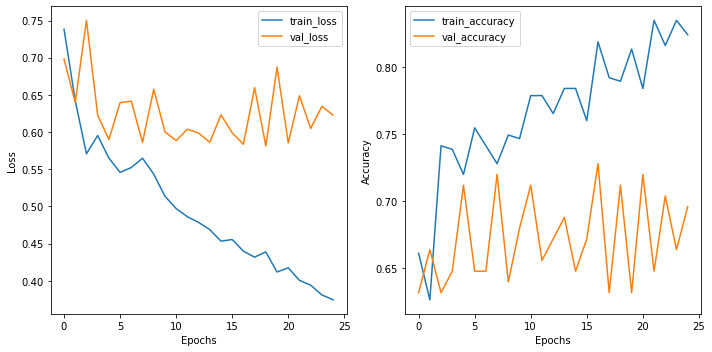

In [48]:
plot_metrics(model_1_results)

Here, we can see that the train loss is decreasing mostly nicely, but validation loss is jumping all over the place, suggesting unstable convergence. Both train and validation accuracy are jumping around as well. I will try and smooth out those plots.

# Model #2

My first simple model was very overfit, let's try making it more complex and adding some hidden layers. Will add convolutional and max pooling. 

In [49]:
model_2 = Sequential()

model_2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', precision, recall])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 12545     
Total params: 31,361
Trainable params: 31,361
Non-trainable params: 0
__________________________________________________

Here we have only 31,361 parameters, which is significantly fewer than the first model. Let's see how it does. 

In [50]:
model_2_results = model_2.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 516ms/step - loss: 0.6570 - accuracy: 0.6053 - precision: 0.7364 - recall: 0.7743 - val_loss: 0.6698 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 239ms/step - loss: 0.6036 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.7039 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 268ms/step - loss: 0.5882 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6559 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 280ms/step - loss: 0.5894 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6544 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 1s 281ms/step - loss: 0.5804 - accuracy: 0.7387 - precision: 0

In [51]:
evaluate_model(model_2)

4/4 [==============================] - 0s 19ms/step - loss: 0.4483 - accuracy: 0.7900 - precision: 0.8023 - recall: 0.9452
---------------------------
Training Loss: 0.447
Training Accuracy: 0.802
Training Precision: 0.79
Training Recall: 0.983
---------------------------
Testing Loss: 0.448
Testing Accuracy: 0.79
Testing Precision: 0.802
Testing Recall: 0.945


Interesting! So our train scores or more or less the same as our first model, with miniscule differences. Testing scores, however, are a little bit higher! Accuracy increased to 79%, and precision increased to 80%. Let's visualize the loss and accuracy functions. 

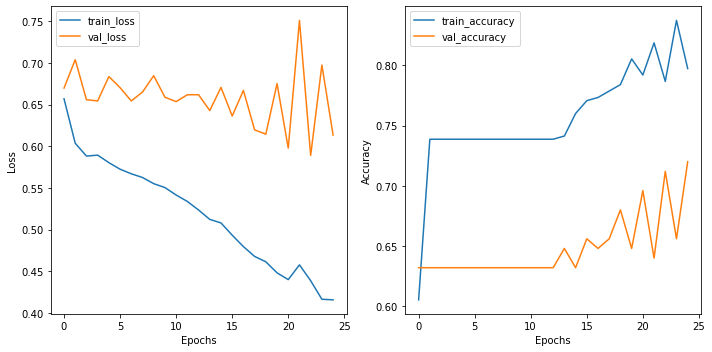

In [53]:
plot_metrics(model_2_results)

Still not that great, but accuracy does seem to be jumping around a little bit less. I'd still like to try and smooth that out a bit more. 

# Model #3

Let's try adding more complexity and see how it imapcts performance. I'll add some more convolutional and maxpooling layers, in addition to hidden dense layers after the flattening layer.

In [54]:
model_3 = Sequential()

model_3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Flatten())
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

This increased the parameters a little bit! We're up to 74,721. Let's see how it does. 

In [55]:
model_3_results = model_3.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 3s 726ms/step - loss: 0.6563 - accuracy: 0.7360 - precision: 0.7500 - recall: 0.9857 - val_loss: 0.6619 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 2s 382ms/step - loss: 0.5967 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.7002 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 372ms/step - loss: 0.5848 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6564 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 2s 418ms/step - loss: 0.5856 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6605 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 2s 381ms/step - loss: 0.5834 - accuracy: 0.7387 - precision: 0

In [56]:
evaluate_model(model_3)

4/4 [==============================] - 0s 32ms/step - loss: 0.4890 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
---------------------------
Training Loss: 0.574
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 0.489
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


That made the results worse all around! Training accuracy and precision dropped to 71%, and recall is at 100%, which seems a little too good to be true. Similarly, testing accuracy and precision dropped to 73% and recall is again at 100%. It's not overfit, but low 70s is not a great score. Let's visualize the loss and accuracy. 

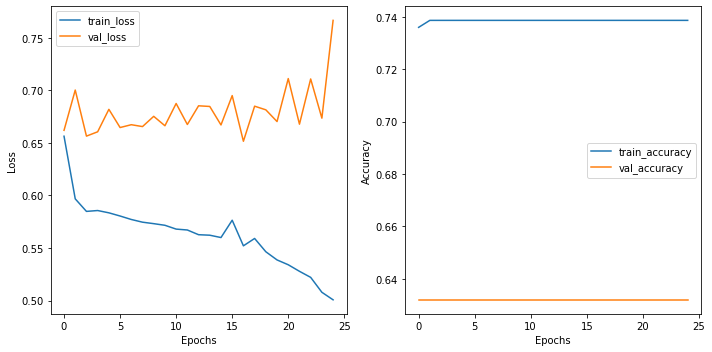

In [57]:
plot_metrics(model_3_results)

Both train and validation accuracy are stalled, not a great sign. Loss is jumping all over the place still. Let's try adding more complexity into the model by increasing all the input units. I'll keep the model the same as the previous one otherwise. 

# Model #4

In [62]:
model_4 = Sequential()

model_4.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Conv2D(128, (3, 3), activation='relu')) # increased from 64 to 128
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Conv2D(64, (3, 3), activation='relu')) # increased from 32 to 64
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu')) # increased from 32 to 64
model_4.add(Dense(32, activation='relu')) # increased from 16 to 32
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             

That successfully increased the parameters, so maybe this will help improve scores after all. Let's check it out. 

In [63]:
model_4_results = model_4.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 613ms/step - loss: 0.6241 - accuracy: 0.7147 - precision: 0.7474 - recall: 0.8114 - val_loss: 0.8574 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 2s 542ms/step - loss: 0.6363 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6546 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 3s 754ms/step - loss: 0.6122 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6526 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 2s 575ms/step - loss: 0.5882 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6809 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 2s 616ms/step - loss: 0.5907 - accuracy: 0.7387 - precision: 0

In [64]:
evaluate_model(model_4)

4/4 [==============================] - 0s 26ms/step - loss: 0.5525 - accuracy: 0.6900 - precision: 0.9773 - recall: 0.5890
---------------------------
Training Loss: 0.435
Training Accuracy: 0.82
Training Precision: 0.82
Training Recall: 0.958
---------------------------
Testing Loss: 0.553
Testing Accuracy: 0.69
Testing Precision: 0.977
Testing Recall: 0.589


That helped the training scores, these are the best ones yet! Training accuracy and precision are both at 82%, and reacll is at 96%. Unfortunately, these are also the worst testing scores yet. Accuracy is at 69%, precision is at 98%, and recall is at 59%. It seems the model is doing a better job at minimizing false negatives in training than in testing, which is interesting. Let's visualize the loss and accuracy: 

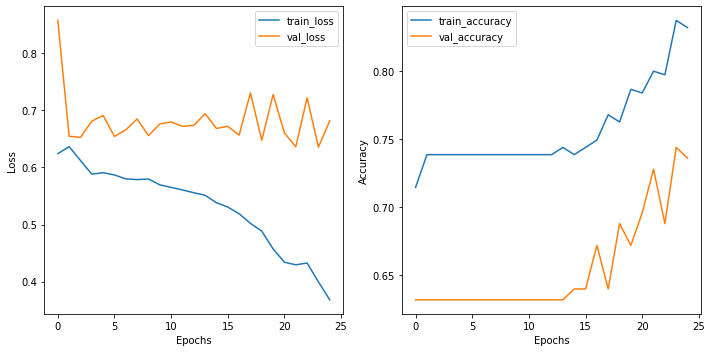

In [65]:
plot_metrics(model_4_results)

This is actually not too bad compared to some of the other graphs, which is surprising. We still have a lot of jumping around and stalling, but not as drastically as you might think. 

Since the last model was so very overfit, let's try adding in some regularization. 

# Model #5

I'll start with just L2 regularization. L2, or Ridge regression, aims to reduce the impact of less important features by driving their coefficients closer to zero, essentially giving them less influence on the model's predictions. This will help prevent the model from memorizing the specific details of the training data, which in turn will help avoid overfitting. Overfitting occurs which  occurs when a model fits the training data too closely, capturing noise rather than the actual patterns. L2 regularization, by penalizing large coefficients, encourages a more generalized model that is better equipped to make accurate predictions on unseen data.

In [66]:
model_5 = Sequential()

model_5.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.01)))

model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

Note that this did not change the number of parameters of the model. Let's see how it does. 

In [67]:
model_5_results = model_5.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 1s 288ms/step - loss: 1.9701 - accuracy: 0.7227 - precision: 0.7603 - recall: 0.8971 - val_loss: 1.8396 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 165ms/step - loss: 1.7119 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 1.6615 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 166ms/step - loss: 1.5055 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 1.4629 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 172ms/step - loss: 1.3594 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 1.3208 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 1s 157ms/step - loss: 1.2102 - accuracy: 0.7387 - precision: 0

In [68]:
evaluate_model(model_5)

4/4 [==============================] - 0s 20ms/step - loss: 0.5830 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
---------------------------
Training Loss: 0.637
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 0.583
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


These are the same results are the third model. Interesting! Let's look at the loss and accuracy. 

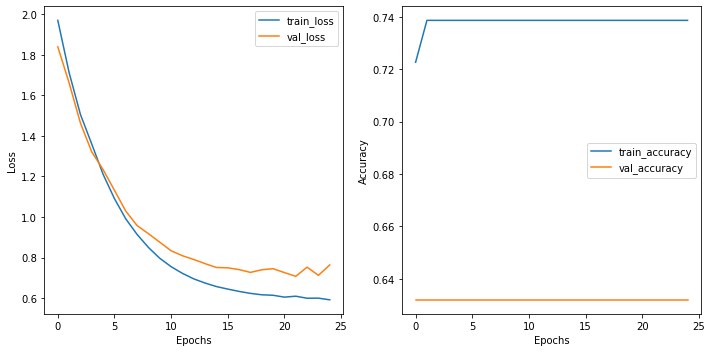

In [69]:
plot_metrics(model_5_results)

It's a shame that the scores aren't that great because look at the loss function!! Accuracy on the other hand is kind of stalled for both train and validation. 

I believe I might have used too strong a regularization. Let's try adjusting it and see if a lower strength is better. 

# Model #6

I will remove regularization from the inner layers, and decrease the strength on both the input and output layers.

In [73]:
model_6 = Sequential()

model_6.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_6.add(MaxPooling2D(pool_size=(2,2)))

model_6.add(Conv2D(128, (3, 3), activation='relu'))
model_6.add(MaxPooling2D(pool_size=(2,2)))

model_6.add(Conv2D(64, (3, 3), activation='relu'))
model_6.add(MaxPooling2D(pool_size=(2,2)))

model_6.add(Flatten())
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)             

Still the same number of parameters. Let's see how it does. 

In [74]:
model_6_results = model_6.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 1s 252ms/step - loss: 0.6527 - accuracy: 0.5893 - precision: 0.7416 - recall: 0.6314 - val_loss: 0.7438 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 165ms/step - loss: 0.6098 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6558 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 165ms/step - loss: 0.6010 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6548 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 149ms/step - loss: 0.5930 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6765 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 1s 149ms/step - loss: 0.5796 - accuracy: 0.7387 - precision: 0

In [75]:
evaluate_model(model_6)

4/4 [==============================] - 0s 21ms/step - loss: 0.5049 - accuracy: 0.7300 - precision: 0.9792 - recall: 0.6438
---------------------------
Training Loss: 0.47
Training Accuracy: 0.794
Training Precision: 0.784
Training Recall: 0.98
---------------------------
Testing Loss: 0.505
Testing Accuracy: 0.73
Testing Precision: 0.979
Testing Recall: 0.644


That helped improved the training scores, but not so much the testing scores. I do note however that the training scores indicate the the model was more successful at minimizing false negatives, while testing seemed better at minimizing false positives. Let's look at the loss and accuracy. 

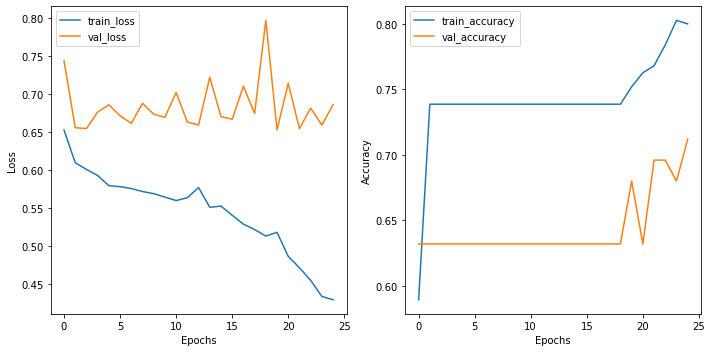

In [76]:
plot_metrics(model_6_results)

It's jumping all over again! I wonder if adding in batch normalization would help the jumping around. Let's try it. 

# Model #7

Batch Normalization is used to help improve training efficiency and stability. It aims to normalize the inputs of each layer in mini-batches by calculating the mean and standard deviation, then scales and shifts the values using learnable parameters. It's used after the activation function to help improve training stability. 

I'll start with adding it after every activation function. 

In [83]:
model_7 = Sequential()

model_7.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Conv2D(128, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Conv2D(64, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Flatten())
model_7.add(Dense(64, activation='relu'))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_7.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
batch_normalization_7 (Batch (None, 29, 29, 128)       512       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 64)      

That added a few more parameters, we're up to 261,633. Let's see how it does.  

In [84]:
model_7_results = model_7.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 3s 783ms/step - loss: 0.8536 - accuracy: 0.6080 - precision: 0.7338 - recall: 0.5829 - val_loss: 0.7039 - val_accuracy: 0.3680 - val_precision: 0.5000 - val_recall: 0.0886
Epoch 2/25
4/4 [==============================] - 2s 606ms/step - loss: 0.5055 - accuracy: 0.7680 - precision: 0.8065 - recall: 0.9025 - val_loss: 0.8173 - val_accuracy: 0.3600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 3s 675ms/step - loss: 0.3953 - accuracy: 0.8080 - precision: 0.8006 - recall: 0.9856 - val_loss: 1.1047 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 [==============================] - 3s 668ms/step - loss: 0.3064 - accuracy: 0.8800 - precision: 0.8742 - recall: 0.9783 - val_loss: 1.5037 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
4/4 [==============================] - 3s 694ms/step - loss: 0.2364 - accurac

In [85]:
evaluate_model(model_7)

4/4 [==============================] - 0s 36ms/step - loss: 4.5594 - accuracy: 0.2700 - precision: 0.0000e+00 - recall: 0.0000e+00
---------------------------
Training Loss: 4.12
Training Accuracy: 0.288
Training Precision: 0.0
Training Recall: 0.0
---------------------------
Testing Loss: 4.56
Testing Accuracy: 0.27
Testing Precision: 0.0
Testing Recall: 0.0


Interesting. Batch normalization kind of erased precision and recall, increased loss and really decreased accuracy. Maybe putting it after every activation function was too intense with such a simple model. Let's try removing 2 of the 3 batch normalizers and see if it helps. But first, let's take a look at the loss and accuracy. 

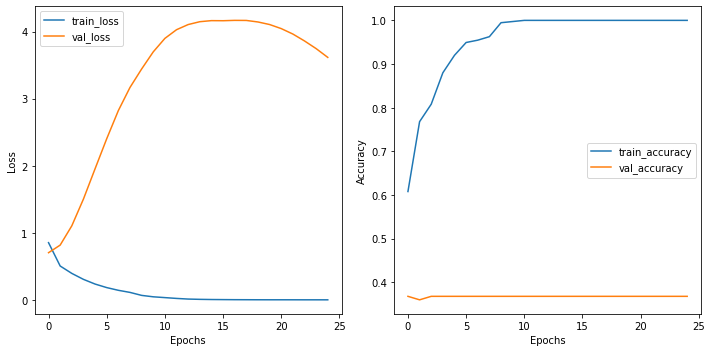

In [86]:
plot_metrics(model_7_results)

Not great! At least they're not jumping all over the place, but the loss function is kind of doing the opposite of what it's meant to do! Let's remove some batch normalization and see if it helps. 

# Model #8

Here, I will remove all batch normalization except for the first one.

In [100]:
model_8 = Sequential()

model_8.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(2,2)))

model_8.add(Conv2D(128, (3, 3), activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2,2)))

model_8.add(Conv2D(64, (3, 3), activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2,2)))

model_8.add(Flatten())
model_8.add(Dense(64, activation='relu'))
model_8.add(Dense(32, activation='relu'))
model_8.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_8.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 6, 6, 64)        

This decreased the parameters slightly, from 261,633 to 260,856. Let's see how it does. 

In [101]:
model_8_results = model_8.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 1s 313ms/step - loss: 0.6861 - accuracy: 0.7013 - precision: 0.7523 - recall: 0.9200 - val_loss: 0.6864 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 222ms/step - loss: 0.5951 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6814 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 218ms/step - loss: 0.5661 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6840 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 212ms/step - loss: 0.5578 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6822 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 1s 212ms/step - loss: 0.5370 - accuracy: 0.7387 - precision: 0

In [102]:
evaluate_model(model_8)

4/4 [==============================] - 0s 28ms/step - loss: 0.5627 - accuracy: 0.8100 - precision: 0.8068 - recall: 0.9726
---------------------------
Training Loss: 0.526
Training Accuracy: 0.762
Training Precision: 0.749
Training Recall: 1.0
---------------------------
Testing Loss: 0.563
Testing Accuracy: 0.81
Testing Precision: 0.807
Testing Recall: 0.973


That looks a lot better. Training accuracy is at 76%, precision at 75%, and recall at 100%, while testing accuracy at 81%, precision at 81%, and recall at 87%. This is pretty decent, but there does seem to be some bias in the training scores, so adding complexity might help even more. 

Let's look at the loss and accuracy first. 

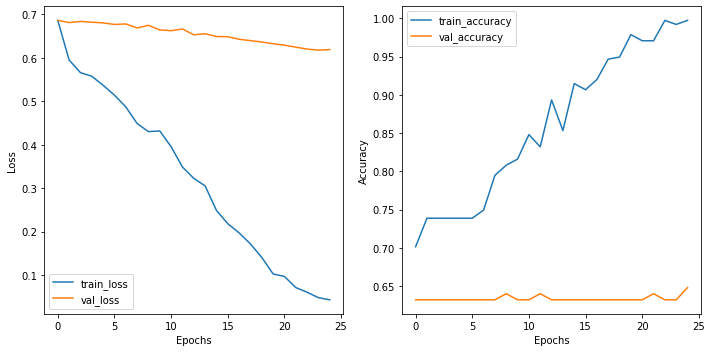

In [104]:
plot_metrics(model_8_results)

Still not great, but both loss and accuracy are jumping around with less intensity. The validation scores are kind of stalled however. I wonder if the changing the activation function would help. 

# Model #9

Let's play around with the different activation functions. I've been using relu for all previous models, but let's see how tanh and sigmoid do. Let's use the last model as reference. 

In [105]:
model_9 = Sequential()

model_9.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_9.add(BatchNormalization())
model_9.add(MaxPooling2D(pool_size=(2,2)))

model_9.add(Conv2D(128, (3, 3), activation='tanh'))
model_9.add(MaxPooling2D(pool_size=(2,2)))

model_9.add(Conv2D(64, (3, 3), activation='tanh'))
model_9.add(MaxPooling2D(pool_size=(2,2)))

model_9.add(Flatten())
model_9.add(Dense(64, activation='tanh'))
model_9.add(Dense(32, activation='tanh'))
model_9.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_9.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 6, 6, 64)        

In [106]:
model_9_results = model_9.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 3s 839ms/step - loss: 0.7568 - accuracy: 0.6613 - precision: 0.7537 - recall: 0.8657 - val_loss: 0.6718 - val_accuracy: 0.6080 - val_precision: 0.6442 - val_recall: 0.8481
Epoch 2/25
4/4 [==============================] - 2s 533ms/step - loss: 0.5968 - accuracy: 0.6747 - precision: 0.7460 - recall: 0.8484 - val_loss: 0.8327 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 [==============================] - 2s 594ms/step - loss: 0.5571 - accuracy: 0.7360 - precision: 0.7380 - recall: 0.9964 - val_loss: 0.7073 - val_accuracy: 0.4960 - val_precision: 0.6739 - val_recall: 0.3924
Epoch 4/25
4/4 [==============================] - 2s 616ms/step - loss: 0.5198 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.7194 - val_accuracy: 0.4960 - val_precision: 0.7000 - val_recall: 0.3544
Epoch 5/25
4/4 [==============================] - 2s 578ms/step - loss: 0.4948 - accuracy: 0.7573 - prec

In [107]:
evaluate_model(model_9)

4/4 [==============================] - 0s 36ms/step - loss: 0.5849 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
---------------------------
Training Loss: 0.572
Training Accuracy: 0.74
Training Precision: 0.738
Training Recall: 0.983
---------------------------
Testing Loss: 0.585
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


Nothing spectactular. Training and testing scores are relatively close, and in the low 70s. Maybe tanh isn't any better than relu. Let's try sigmoid and see if it helps. 

But first, let's take a look at the loss and accuracy. 

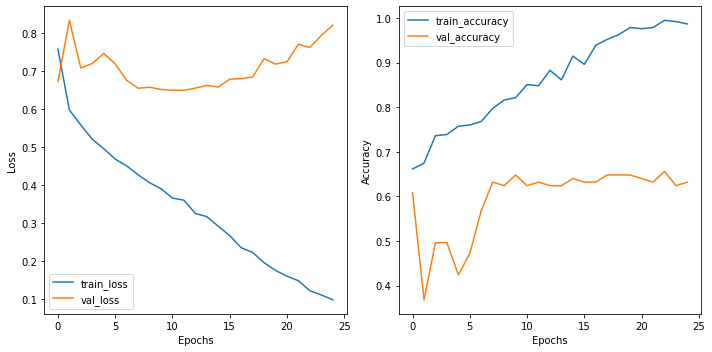

In [108]:
plot_metrics(model_9_results)

Loss and accuracy are still jumping around, let's try sigmoid. 

# Model #10

In [112]:
model_10 = Sequential()

model_10.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='sigmoid', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_10.add(BatchNormalization())
model_10.add(MaxPooling2D(pool_size=(2,2)))

model_10.add(Conv2D(128, (3, 3), activation='sigmoid'))
model_10.add(MaxPooling2D(pool_size=(2,2)))

model_10.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_10.add(MaxPooling2D(pool_size=(2,2)))

model_10.add(Flatten())
model_10.add(Dense(64, activation='sigmoid'))
model_10.add(Dense(32, activation='sigmoid'))
model_10.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_10.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 6, 6, 64)        

In [113]:
model_10_results = model_10.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 3s 793ms/step - loss: 0.5899 - accuracy: 0.7387 - precision: 0.7368 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 2s 541ms/step - loss: 0.5774 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6704 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 2s 617ms/step - loss: 0.5764 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6859 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 3s 626ms/step - loss: 0.5747 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6947 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 2s 547ms/step - loss: 0.5756 - accuracy: 0.7387 - precision: 0

In [114]:
evaluate_model(model_10)

4/4 [==============================] - 0s 33ms/step - loss: 0.6041 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
---------------------------
Training Loss: 0.633
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 0.604
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


About the same scores as some of the previous models. So sigmoid is also not necessarily better than relu. Let's stick with relu for now. 

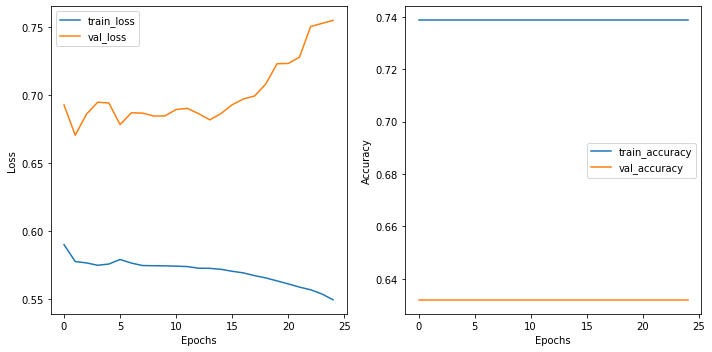

In [116]:
plot_metrics(model_10_results)

Let's try adding in some complexity and introducing early stopping to see if it helps. 

# Model #11

I'll add complexity by adding an additional hidden dense layer, and increasing the filters in the input layer to 64. 

In some of the earlier iterations, I noticed that the scores for the last few epochs remained constant. To address this, I am going to try using early stopping in my training process. Early stopping is when the model continuously monitors the validation loss (or whatever you would like to monitor), and if there is no improvement over a specified number of consecutive epochs (known as the patience), the training process is stopped. This helps prevent overfitting. 

In [121]:
# we will monitor the validation loss
# when it stops decreasing, wait 3 epochs before stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [122]:
model_11 = Sequential()

model_11.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_11.add(MaxPooling2D(pool_size=(2,2)))

model_11.add(Conv2D(128, (3, 3), activation='relu'))
model_11.add(MaxPooling2D(pool_size=(2,2)))

model_11.add(Conv2D(64, (3, 3), activation='relu'))
model_11.add(MaxPooling2D(pool_size=(2,2)))

model_11.add(Flatten())
model_11.add(Dense(128, activation='relu'))
model_11.add(Dense(64, activation='relu'))
model_11.add(Dense(32, activation='relu'))
model_11.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_11.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 2304)            

We've successfully added more parameters! Let's see how this model does with the added complexity and early stopping implemented. 

In [123]:
model_11_results = model_11.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              callbacks=early_stop)

Epoch 1/25
4/4 [==============================] - 1s 310ms/step - loss: 0.6722 - accuracy: 0.6080 - precision: 0.7316 - recall: 0.7943 - val_loss: 0.6571 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 249ms/step - loss: 0.6183 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6659 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 240ms/step - loss: 0.5858 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6598 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 247ms/step - loss: 0.5832 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6752 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000


In [124]:
evaluate_model(model_11)

4/4 [==============================] - 0s 18ms/step - loss: 0.5709 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
---------------------------
Training Loss: 0.603
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 0.571
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


No changes! How interesting.. let's try the same model with tanh instead. 

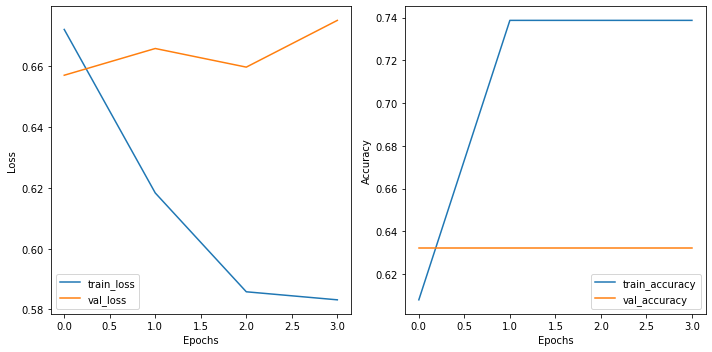

In [126]:
plot_metrics(model_11_results)

# Model #12

Same model, but let's use tanh instead since we saw slightly different results with it earlier. 

In [127]:
model_12 = Sequential()

model_12.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_12.add(MaxPooling2D(pool_size=(2,2)))

model_12.add(Conv2D(128, (3, 3), activation='tanh'))
model_12.add(MaxPooling2D(pool_size=(2,2)))

model_12.add(Conv2D(64, (3, 3), activation='tanh'))
model_12.add(MaxPooling2D(pool_size=(2,2)))

model_12.add(Flatten())
model_12.add(Dense(128, activation='tanh'))
model_12.add(Dense(64, activation='tanh'))
model_12.add(Dense(32, activation='tanh'))
model_12.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_12.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_12.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 2304)            

In [128]:
model_12_results = model_12.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25, 
                              callbacks=early_stop)

Epoch 1/25
4/4 [==============================] - 2s 424ms/step - loss: 0.6300 - accuracy: 0.7307 - precision: 0.7352 - recall: 0.9914 - val_loss: 0.7479 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 3s 779ms/step - loss: 0.5933 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6827 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 3s 788ms/step - loss: 0.5643 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6745 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 3s 712ms/step - loss: 0.5611 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6635 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 3s 643ms/step - loss: 0.5564 - accuracy: 0.7387 - precision: 0

In [129]:
evaluate_model(model_12)

4/4 [==============================] - 0s 53ms/step - loss: 0.4336 - accuracy: 0.8000 - precision: 0.8354 - recall: 0.9041
---------------------------
Training Loss: 0.408
Training Accuracy: 0.826
Training Precision: 0.816
Training Recall: 0.975
---------------------------
Testing Loss: 0.434
Testing Accuracy: 0.8
Testing Precision: 0.835
Testing Recall: 0.904


This is not too bad! Training accuracy is at 83%, precision at 82% and recall is even higher at 98%. Test accuracy is at 80%, precision at 84%, and recall at 90%. It seems like tanh is still in the running. Let's check out the loss and accuracy. 

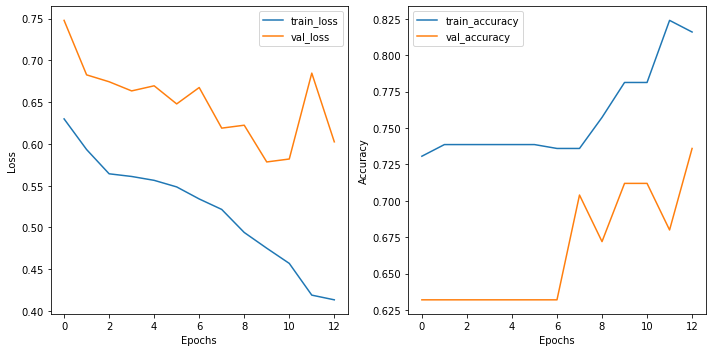

In [130]:
plot_metrics(model_12_results)

Still kind of jumping all over the place, but it has more of an obvious direction to it. 

Now, something I noticed earlier on when I set the binary labels was that we have a class imbalance. As this could be impacting accuracy, let's try adjusting the class weights and see how it impacts scores. 

# Model #13

Let's adjust the class weights. Class 0 (or normal) had fewer images, so the weight for that class should be higher than class 1 (or the abnormal set). Let's try it. 

In [147]:
#y_ints = [y.argmax() for y in binary_train_labels]
class_weights = compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(binary_train_labels),
                                                  y=binary_train_labels)

# turn into dict so it can be put in the fit statement
class_weights_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

In [148]:
# confirm the weights look accurate
class_weights_dict

{0: 1.7361111111111112, 1: 0.702247191011236}

This looks good! Let's try it out in a model and see what it does. 

In [149]:
model_13 = Sequential()

model_13.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_13.add(MaxPooling2D(pool_size=(2,2)))

model_13.add(Conv2D(128, (3, 3), activation='relu'))
model_13.add(MaxPooling2D(pool_size=(2,2)))

model_13.add(Conv2D(64, (3, 3), activation='relu'))
model_13.add(MaxPooling2D(pool_size=(2,2)))

model_13.add(Flatten())
model_13.add(Dense(128, activation='relu'))
model_13.add(Dense(64, activation='relu'))
model_13.add(Dense(32, activation='relu'))
model_13.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_13.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_13.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 2304)            

In [150]:
model_13_results = model_13.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25, 
                              callbacks=early_stop,
                              class_weight=class_weights_dict)

Epoch 1/25
4/4 [==============================] - 2s 532ms/step - loss: 0.6743 - accuracy: 0.5387 - precision: 0.7342 - recall: 0.6629 - val_loss: 0.6760 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 249ms/step - loss: 0.6729 - accuracy: 0.7280 - precision: 0.7358 - recall: 0.9856 - val_loss: 0.6845 - val_accuracy: 0.5680 - val_precision: 0.6437 - val_recall: 0.7089
Epoch 3/25
4/4 [==============================] - 1s 226ms/step - loss: 0.6659 - accuracy: 0.6853 - precision: 0.7849 - recall: 0.7906 - val_loss: 0.6737 - val_accuracy: 0.6400 - val_precision: 0.6635 - val_recall: 0.8734
Epoch 4/25
4/4 [==============================] - 1s 228ms/step - loss: 0.6581 - accuracy: 0.7173 - precision: 0.7568 - recall: 0.9097 - val_loss: 0.6833 - val_accuracy: 0.4800 - val_precision: 0.6346 - val_recall: 0.4177
Epoch 5/25
4/4 [==============================] - 1s 233ms/step - loss: 0.6459 - accuracy: 0.6347 - precision: 0

In [151]:
evaluate_model(model_13)

4/4 [==============================] - 0s 30ms/step - loss: 1.2537 - accuracy: 0.3500 - precision: 1.0000 - recall: 0.1096
---------------------------
Training Loss: 0.606
Training Accuracy: 0.674
Training Precision: 0.918
Training Recall: 0.596
---------------------------
Testing Loss: 1.25
Testing Accuracy: 0.35
Testing Precision: 1.0
Testing Recall: 0.11


Both training and testing scores dropped significantly. The low training scores suggests not enough complexity. Maybe the early stopping was too soon. 

The model is pretty overfit, let's try adding more regularization. 

But first, let's look at the loss and accuracy. 

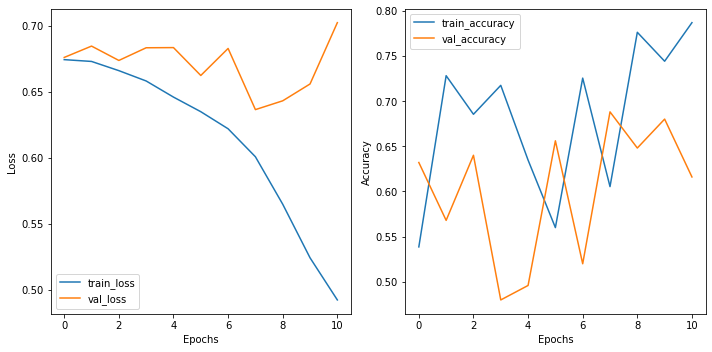

In [152]:
plot_metrics(model_13_results)

That made things a lot worse it seems like! Look at how much accuracy is fluctuating. Validation loss also seems to increase at some point, alhtough train loss is performing beautifully. Let's try regularization. If that doesn't help much, I'll consider adding batch normalization in again after the activations. 

# Model #14

I'd like to see what the impact of dropout regularization is. Dropout involves randomly deactivating a specified percentage of neurons between layers during each training iteration. This technique prevents the model from memorizing specific details of the training set, which produces a more robust and generalized learning process.

I'll add dropout after each max pooling layer, dropping out 20% of the neurons each time. 

In [153]:
model_14 = Sequential()

model_14.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.2))

model_14.add(Conv2D(128, (3, 3), activation='relu'))
model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.2))

model_14.add(Conv2D(64, (3, 3), activation='relu'))
model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.2))

model_14.add(Flatten())
model_14.add(Dense(64, activation='relu'))
model_14.add(Dense(32, activation='relu'))
model_14.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_14.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_14.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 12, 12, 64)      

In [154]:
model_14_results = model_14.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25, 
                              callbacks=early_stop,
                              class_weight=class_weights_dict)

Epoch 1/25
4/4 [==============================] - 1s 261ms/step - loss: 0.6736 - accuracy: 0.6240 - precision: 0.7628 - recall: 0.5971 - val_loss: 0.6866 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 192ms/step - loss: 0.6710 - accuracy: 0.6800 - precision: 0.7508 - recall: 0.8484 - val_loss: 0.6811 - val_accuracy: 0.6640 - val_precision: 0.6581 - val_recall: 0.9747
Epoch 3/25
4/4 [==============================] - 1s 190ms/step - loss: 0.6658 - accuracy: 0.7307 - precision: 0.7444 - recall: 0.9675 - val_loss: 0.6720 - val_accuracy: 0.6480 - val_precision: 0.6446 - val_recall: 0.9873
Epoch 4/25
4/4 [==============================] - 1s 185ms/step - loss: 0.6593 - accuracy: 0.7360 - precision: 0.7618 - recall: 0.9350 - val_loss: 0.6750 - val_accuracy: 0.5600 - val_precision: 0.6463 - val_recall: 0.6709
Epoch 5/25
4/4 [==============================] - 1s 311ms/step - loss: 0.6620 - accuracy: 0.5707 - precision: 0

In [155]:
evaluate_model(model_14)

4/4 [==============================] - 0s 25ms/step - loss: 0.7454 - accuracy: 0.3500 - precision: 0.9000 - recall: 0.1233
---------------------------
Training Loss: 0.664
Training Accuracy: 0.564
Training Precision: 0.774
Training Recall: 0.548
---------------------------
Testing Loss: 0.745
Testing Accuracy: 0.35
Testing Precision: 0.9
Testing Recall: 0.123


This only made things worse! I think the model might be getting stopped too soon, let's remove early stopping from now on. 

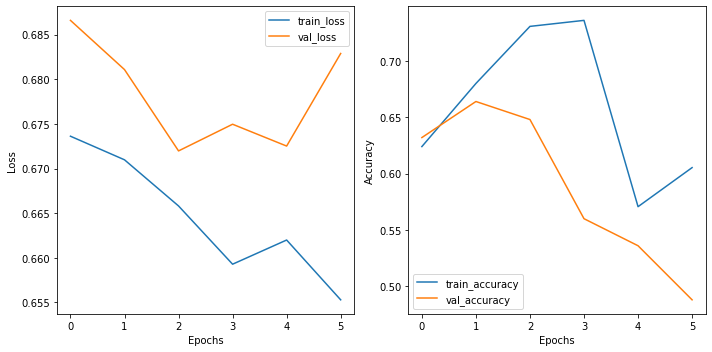

In [156]:
plot_metrics(model_14_results)

The loss and accuracy are getting there. Less jumping around but still not much of a curve there. Let's try model 14 again but without early stopping and see how the results change. 

In [157]:
model_14_results = model_14.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
4/4 [==============================] - 1s 189ms/step - loss: 0.6416 - accuracy: 0.5813 - precision: 0.8093 - recall: 0.5668 - val_loss: 0.6773 - val_accuracy: 0.5040 - val_precision: 0.6349 - val_recall: 0.5063
Epoch 2/25
4/4 [==============================] - 1s 175ms/step - loss: 0.6385 - accuracy: 0.6187 - precision: 0.7991 - recall: 0.6462 - val_loss: 0.6788 - val_accuracy: 0.5280 - val_precision: 0.6515 - val_recall: 0.5443
Epoch 3/25
4/4 [==============================] - 1s 174ms/step - loss: 0.6226 - accuracy: 0.6107 - precision: 0.8466 - recall: 0.5776 - val_loss: 0.6847 - val_accuracy: 0.5120 - val_precision: 0.6552 - val_recall: 0.4810
Epoch 4/25
4/4 [==============================] - 1s 174ms/step - loss: 0.6279 - accuracy: 0.6347 - precision: 0.8043 - recall: 0.6679 - val_loss: 0.6640 - val_accuracy: 0.6160 - val_precision: 0.6962 - val_recall: 0.6962
Epoch 5/25
4/4 [==============================] - 1s 181ms/step - loss: 0.6172 - accuracy: 0.6240 - precision: 0

In [158]:
evaluate_model(model_14)

4/4 [==============================] - 0s 26ms/step - loss: 1.1212 - accuracy: 0.5500 - precision: 0.9667 - recall: 0.3973
---------------------------
Training Loss: 0.462
Training Accuracy: 0.828
Training Precision: 0.93
Training Recall: 0.82
---------------------------
Testing Loss: 1.12
Testing Accuracy: 0.55
Testing Precision: 0.967
Testing Recall: 0.397


That increased the training scores, so I think I was right and early stopping was stopping the training process too soon. I will keep it in mind, but for now, let's drop early stopping. 

My model is pretty overfit here.

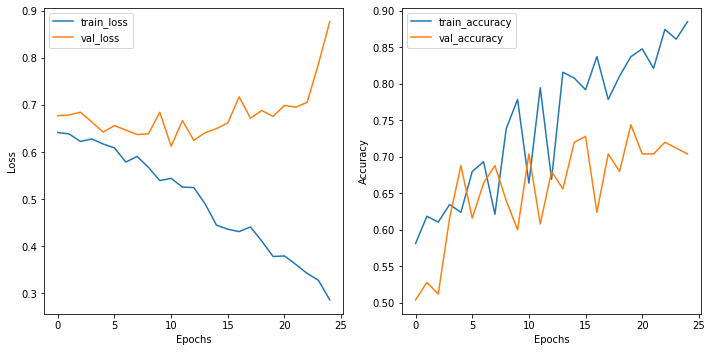

In [159]:
plot_metrics(model_14_results)

Loss and accuracy are jumping all over the place still. I wonder how the batch_size and epochs impact the scores. Let's experiment with model #12, as that is the best one so far. 

So, using model 12, I will iterate through a few different batch sizes and epochs, then look at the average accuracy. To remind myself, here are the results of model 12: 

In [161]:
evaluate_model(model_12)

4/4 [==============================] - 0s 20ms/step - loss: 0.4336 - accuracy: 0.8000 - precision: 0.8354 - recall: 0.9041
---------------------------
Training Loss: 0.408
Training Accuracy: 0.826
Training Precision: 0.816
Training Recall: 0.975
---------------------------
Testing Loss: 0.434
Testing Accuracy: 0.8
Testing Precision: 0.835
Testing Recall: 0.904


Let's do the loop!

In [162]:
model_12_loop = {}
batch_sizes = [50, 100, 150]
epochs = [15, 25, 50]

for batch_size in batch_sizes:
    for epoch in epochs:
        model = model_12
        
        model.compile(optimizer='Adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', precision, recall])
        
        # Train the model
        model_results = model.fit(train_images, 
                                  binary_train_labels, 
                                  batch_size=batch_size, 
                                  epochs=epoch,
                                  validation_split=0.25,
                                  class_weight=class_weights_dict)
        
        # Store the results in a dictionary using the combination of batch size and epochs as keys
        model_12_loop[(batch_size, epoch)] = model_results

Epoch 1/15
8/8 [==============================] - 2s 211ms/step - loss: 0.6094 - accuracy: 0.6373 - precision: 0.8170 - recall: 0.7143 - val_loss: 0.6455 - val_accuracy: 0.5920 - val_precision: 0.7917 - val_recall: 0.4810
Epoch 2/15
8/8 [==============================] - 1s 157ms/step - loss: 0.4980 - accuracy: 0.7360 - precision: 0.9159 - recall: 0.7076 - val_loss: 0.5747 - val_accuracy: 0.6960 - val_precision: 0.7253 - val_recall: 0.8354
Epoch 3/15
8/8 [==============================] - 1s 161ms/step - loss: 0.4276 - accuracy: 0.8213 - precision: 0.9134 - recall: 0.8375 - val_loss: 0.5630 - val_accuracy: 0.7360 - val_precision: 0.7500 - val_recall: 0.8734
Epoch 4/15
8/8 [==============================] - 1s 154ms/step - loss: 0.3891 - accuracy: 0.7947 - precision: 0.9348 - recall: 0.7762 - val_loss: 0.6011 - val_accuracy: 0.7520 - val_precision: 0.7353 - val_recall: 0.9494
Epoch 5/15
8/8 [==============================] - 1s 153ms/step - loss: 0.3292 - accuracy: 0.8587 - precision: 0

Epoch 23/25
8/8 [==============================] - 3s 409ms/step - loss: 0.0019 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5302 - val_accuracy: 0.7440 - val_precision: 0.7327 - val_recall: 0.9367
Epoch 24/25
8/8 [==============================] - 3s 352ms/step - loss: 0.0017 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5323 - val_accuracy: 0.7440 - val_precision: 0.7327 - val_recall: 0.9367
Epoch 25/25
8/8 [==============================] - 3s 363ms/step - loss: 0.0016 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5327 - val_accuracy: 0.7440 - val_precision: 0.7327 - val_recall: 0.9367
Epoch 1/50
8/8 [==============================] - 3s 401ms/step - loss: 0.0126 - accuracy: 0.9947 - precision: 0.9282 - recall: 0.9803 - val_loss: 1.6007 - val_accuracy: 0.6960 - val_precision: 0.7113 - val_recall: 0.8734
Epoch 2/50
8/8 [==============================] - 3s 333ms/step - loss: 0.0562 - accuracy: 0.9893 - precision

Epoch 35/50
8/8 [==============================] - 3s 353ms/step - loss: 8.8268e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5891 - val_accuracy: 0.7360 - val_precision: 0.7396 - val_recall: 0.8987
Epoch 36/50
8/8 [==============================] - 3s 357ms/step - loss: 8.7516e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5936 - val_accuracy: 0.7360 - val_precision: 0.7396 - val_recall: 0.8987
Epoch 37/50
8/8 [==============================] - 3s 356ms/step - loss: 8.6793e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.5981 - val_accuracy: 0.7360 - val_precision: 0.7396 - val_recall: 0.8987
Epoch 38/50
8/8 [==============================] - 3s 372ms/step - loss: 8.6068e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6022 - val_accuracy: 0.7360 - val_precision: 0.7396 - val_recall: 0.8987
Epoch 39/50
8/8 [==============================] - 3s 358ms/step - loss: 8.5430e-04 - accura

4/4 [==============================] - 1s 275ms/step - loss: 4.4539e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.1863 - val_accuracy: 0.7280 - val_precision: 0.7320 - val_recall: 0.8987
Epoch 18/50
4/4 [==============================] - 1s 281ms/step - loss: 4.3757e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.1867 - val_accuracy: 0.7200 - val_precision: 0.7245 - val_recall: 0.8987
Epoch 19/50
4/4 [==============================] - 1s 280ms/step - loss: 4.3050e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.1823 - val_accuracy: 0.7200 - val_precision: 0.7245 - val_recall: 0.8987
Epoch 20/50
4/4 [==============================] - 1s 276ms/step - loss: 4.2403e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.1571 - val_accuracy: 0.7280 - val_precision: 0.7320 - val_recall: 0.8987
Epoch 21/50
4/4 [==============================] - 1s 278ms/step - loss: 4.1823e-04 - accuracy: 1.0000 -

3/3 [==============================] - 1s 379ms/step - loss: 3.5765e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2684 - val_accuracy: 0.7120 - val_precision: 0.7216 - val_recall: 0.8861
Epoch 25/25
3/3 [==============================] - 1s 383ms/step - loss: 3.5749e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2449 - val_accuracy: 0.7120 - val_precision: 0.7172 - val_recall: 0.8987
Epoch 1/50
3/3 [==============================] - 2s 588ms/step - loss: 3.5754e-04 - accuracy: 1.0000 - precision: 0.9255 - recall: 0.9775 - val_loss: 2.2056 - val_accuracy: 0.7360 - val_precision: 0.7255 - val_recall: 0.9367
Epoch 2/50
3/3 [==============================] - 1s 396ms/step - loss: 3.5764e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2540 - val_accuracy: 0.7200 - val_precision: 0.7340 - val_recall: 0.8734
Epoch 3/50
3/3 [==============================] - 1s 384ms/step - loss: 3.5739e-04 - accuracy: 1.0000 - pr

And now, let's get the average accuracy for each batch size/epoch combination and see where the results are the best. 

In [163]:
average_accuracy = {}

for batch_size in batch_sizes:
    for epoch in epochs:
        history = model_12_loop[(batch_size, epoch)].history
        avg_acc = sum(history['accuracy']) / len(history['accuracy'])
        average_accuracy[(batch_size, epoch)] = avg_acc

for batch_size in batch_sizes:
    for epoch in epochs:
        print(f"Batch Size {batch_size}, Epochs {epoch}:")
        print(f"Average Accuracy: {average_accuracy[(batch_size, epoch)]}")

Batch Size 50, Epochs 15:
Average Accuracy: 0.8992000023523966
Batch Size 50, Epochs 25:
Average Accuracy: 0.989866669178009
Batch Size 50, Epochs 50:
Average Accuracy: 0.9987733352184296
Batch Size 100, Epochs 15:
Average Accuracy: 0.9987555623054505
Batch Size 100, Epochs 25:
Average Accuracy: 0.9991466689109803
Batch Size 100, Epochs 50:
Average Accuracy: 1.0
Batch Size 150, Epochs 15:
Average Accuracy: 1.0
Batch Size 150, Epochs 25:
Average Accuracy: 1.0
Batch Size 150, Epochs 50:
Average Accuracy: 1.0


So it looks like the most of these options are going to overfit, except for batch size 50, epochs 15, and maybe batch size 50, epochs 25. Let's try them both! 

# Model #15

In [164]:
model_15 = Sequential()

model_15.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.2))

model_15.add(Conv2D(128, (3, 3), activation='relu'))
model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.2))

model_15.add(Conv2D(64, (3, 3), activation='relu'))
model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.2))

model_15.add(Flatten())
model_15.add(Dense(64, activation='relu'))
model_15.add(Dense(32, activation='relu'))
model_15.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_15.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_15.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 12, 12, 64)      

In [165]:
# try batch size 50 and 15 epochs first
model_15_results = model_15.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=15,
                              class_weight=class_weights_dict)

Epoch 1/15
8/8 [==============================] - 4s 522ms/step - loss: 0.6746 - accuracy: 0.6133 - precision: 0.7385 - recall: 0.7697 - val_loss: 0.6775 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/15
8/8 [==============================] - 3s 340ms/step - loss: 0.6721 - accuracy: 0.5973 - precision: 0.7461 - recall: 0.6895 - val_loss: 0.6833 - val_accuracy: 0.6160 - val_precision: 0.6566 - val_recall: 0.8228
Epoch 3/15
8/8 [==============================] - 3s 356ms/step - loss: 0.6682 - accuracy: 0.6880 - precision: 0.7339 - recall: 0.9061 - val_loss: 0.6703 - val_accuracy: 0.6160 - val_precision: 0.6566 - val_recall: 0.8228
Epoch 4/15
8/8 [==============================] - 3s 345ms/step - loss: 0.6681 - accuracy: 0.5120 - precision: 0.7733 - recall: 0.4801 - val_loss: 0.6901 - val_accuracy: 0.4800 - val_precision: 0.6591 - val_recall: 0.3671
Epoch 5/15
8/8 [==============================] - 3s 341ms/step - loss: 0.6540 - accuracy: 0.5733 - precision: 0

In [166]:
evaluate_model(model_15)

4/4 [==============================] - 0s 27ms/step - loss: 0.8813 - accuracy: 0.3000 - precision: 1.0000 - recall: 0.0411
---------------------------
Training Loss: 0.656
Training Accuracy: 0.568
Training Precision: 0.88
Training Recall: 0.455
---------------------------
Testing Loss: 0.881
Testing Accuracy: 0.3
Testing Precision: 1.0
Testing Recall: 0.0411


Not great results! Both training and testing scores are pretty low, suggesting not enough complexity, or maybe just not enough epochs to train the data on. Let's look at the loss and accuracy. 

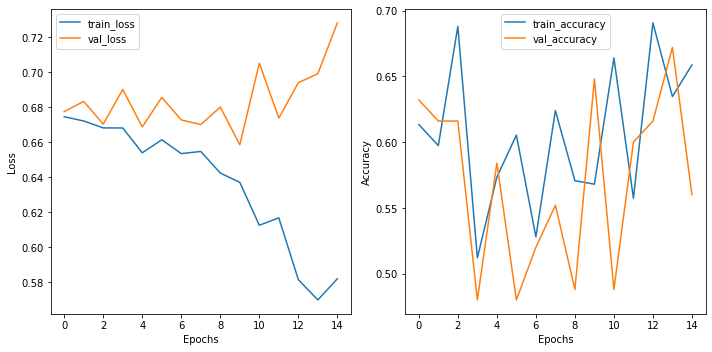

In [167]:
plot_metrics(model_15_results)

So sporadic! It's really struggling to converge on a minimium. Let's try 25 epochs and see if the results are better. 

In [168]:
model_15_results = model_15.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 1s 110ms/step - loss: 0.5375 - accuracy: 0.6960 - precision: 0.9015 - recall: 0.6606 - val_loss: 0.7182 - val_accuracy: 0.6720 - val_precision: 0.7111 - val_recall: 0.8101
Epoch 2/25
8/8 [==============================] - 1s 117ms/step - loss: 0.4968 - accuracy: 0.7280 - precision: 0.8995 - recall: 0.7112 - val_loss: 0.7480 - val_accuracy: 0.6080 - val_precision: 0.7273 - val_recall: 0.6076
Epoch 3/25
8/8 [==============================] - 1s 109ms/step - loss: 0.4943 - accuracy: 0.7787 - precision: 0.9042 - recall: 0.7834 - val_loss: 0.8676 - val_accuracy: 0.6000 - val_precision: 0.7458 - val_recall: 0.5570
Epoch 4/25
8/8 [==============================] - 1s 117ms/step - loss: 0.4454 - accuracy: 0.7947 - precision: 0.9167 - recall: 0.7942 - val_loss: 0.7120 - val_accuracy: 0.7360 - val_precision: 0.7347 - val_recall: 0.9114
Epoch 5/25
8/8 [==============================] - 1s 118ms/step - loss: 0.4040 - accuracy: 0.8347 - precision: 0

In [169]:
evaluate_model(model_15)

4/4 [==============================] - 0s 25ms/step - loss: 2.4363 - accuracy: 0.5100 - precision: 0.9286 - recall: 0.3562
---------------------------
Training Loss: 0.512
Training Accuracy: 0.882
Training Precision: 0.946
Training Recall: 0.885
---------------------------
Testing Loss: 2.44
Testing Accuracy: 0.51
Testing Precision: 0.929
Testing Recall: 0.356


Great training scores, not so great testing scores. It seems like 25 epochs is better than 15 at least. This overfit the model - let's try adding some more regularization. 

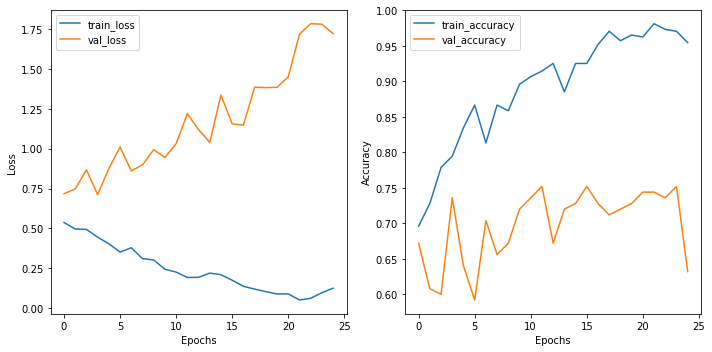

In [171]:
plot_metrics(model_15_results)

# Model #16

Let's increase the dropout rates. 

In [176]:
model_16 = Sequential()

model_16.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.3)) # increased

model_16.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))) # added
model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.3)) # increased

model_16.add(Conv2D(64, (3, 3), activation='relu'))
model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.2))

model_16.add(Flatten())
model_16.add(Dense(64, activation='relu'))
model_16.add(Dense(32, activation='relu'))
model_16.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_16.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 12, 12, 64)      

In [177]:
model_16_results = model_16.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 1s 154ms/step - loss: 0.6854 - accuracy: 0.6960 - precision: 0.7519 - recall: 0.8314 - val_loss: 0.6913 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 1s 111ms/step - loss: 0.6777 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6858 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 1s 137ms/step - loss: 0.6746 - accuracy: 0.7387 - precision: 0.7412 - recall: 0.9928 - val_loss: 0.6848 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 4s 450ms/step - loss: 0.6720 - accuracy: 0.6587 - precision: 0.7596 - recall: 0.7870 - val_loss: 0.6778 - val_accuracy: 0.6320 - val_precision: 0.6435 - val_recall: 0.9367
Epoch 5/25
8/8 [==============================] - 3s 383ms/step - loss: 0.6768 - accuracy: 0.7440 - precision: 0

In [178]:
evaluate_model(model_16)

4/4 [==============================] - 0s 34ms/step - loss: 0.8237 - accuracy: 0.6300 - precision: 0.9500 - recall: 0.5205
---------------------------
Training Loss: 0.484
Training Accuracy: 0.822
Training Precision: 0.911
Training Recall: 0.831
---------------------------
Testing Loss: 0.824
Testing Accuracy: 0.63
Testing Precision: 0.95
Testing Recall: 0.521


Maybe a little bit better, not that much though. 

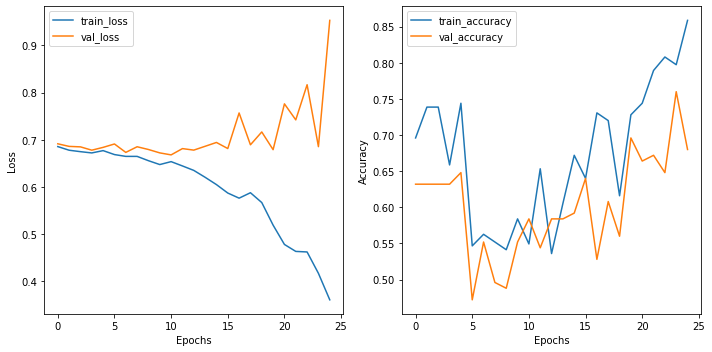

In [179]:
plot_metrics(model_16_results)

# Model #17

Let's try adjusting the numbers of units in each of the layers. Start by doubling them all. 

In [180]:
model_17 = Sequential()

model_17.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.3))

model_17.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))) # added
model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.3))

model_17.add(Conv2D(128, (3, 3), activation='relu'))
model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.2))

model_17.add(Flatten())
model_17.add(Dense(128, activation='relu'))
model_17.add(Dense(64, activation='relu'))
model_17.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_17.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_17.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 12, 12, 128)     

Wow! Look at how many more parameters that created! Let's see how the model does. 

In [181]:
model_17_results = model_17.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 337ms/step - loss: 0.6849 - accuracy: 0.5307 - precision: 0.7915 - recall: 0.5314 - val_loss: 0.6849 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 5s 616ms/step - loss: 0.6794 - accuracy: 0.6533 - precision: 0.7410 - recall: 0.8159 - val_loss: 0.7044 - val_accuracy: 0.4480 - val_precision: 0.6667 - val_recall: 0.2532
Epoch 3/25
8/8 [==============================] - 6s 768ms/step - loss: 0.6762 - accuracy: 0.5067 - precision: 0.7527 - recall: 0.4946 - val_loss: 0.6834 - val_accuracy: 0.6560 - val_precision: 0.6525 - val_recall: 0.9747
Epoch 4/25
8/8 [==============================] - 6s 718ms/step - loss: 0.6742 - accuracy: 0.6347 - precision: 0.7500 - recall: 0.7581 - val_loss: 0.6906 - val_accuracy: 0.4880 - val_precision: 0.6190 - val_recall: 0.4937
Epoch 5/25
8/8 [==============================] - 6s 703ms/step - loss: 0.6684 - accuracy: 0.5253 - precision: 0

In [182]:
evaluate_model(model_17)

4/4 [==============================] - 0s 68ms/step - loss: 0.6586 - accuracy: 0.7800 - precision: 0.9048 - recall: 0.7808
---------------------------
Training Loss: 0.453
Training Accuracy: 0.902
Training Precision: 0.907
Training Recall: 0.961
---------------------------
Testing Loss: 0.659
Testing Accuracy: 0.78
Testing Precision: 0.905
Testing Recall: 0.781


This is pretty good for the training set - accuracy, precision, and recall are all in the 90s! However, and unsurprisingly, this is overfit, and the test set seems to be prioritizing minimizing false positives over false negatives. Let's look at the loss and accuracy. 

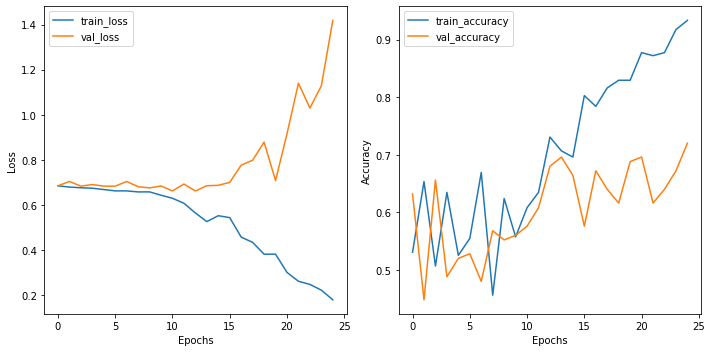

In [183]:
plot_metrics(model_17_results)

The validation loss is interesting - it curves back up and starts to get jagged around 20 epochs. Maybe 25 was too many. Accuracy is jumping all over the place still. Let's try halving all of the units next. 

# Model #18

In [184]:
model_18 = Sequential()

model_18.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.3))

model_18.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))) # added
model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.2))

model_18.add(Conv2D(32, (3, 3), activation='relu'))
model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.2))

model_18.add(Flatten())
model_18.add(Dense(32, activation='relu'))
model_18.add(Dense(16, activation='relu'))
model_18.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_18.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_18.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 12, 12, 32)      

This really decreased the parameters! We went from over 1 million to just 74,721! Let's see how it does. 

In [185]:
model_18_results = model_18.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 1s 127ms/step - loss: 0.6819 - accuracy: 0.6427 - precision: 0.7566 - recall: 0.8171 - val_loss: 0.6916 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 1s 89ms/step - loss: 0.6778 - accuracy: 0.7413 - precision: 0.7406 - recall: 1.0000 - val_loss: 0.6917 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 1s 82ms/step - loss: 0.6749 - accuracy: 0.7147 - precision: 0.7361 - recall: 0.9567 - val_loss: 0.6908 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 1s 83ms/step - loss: 0.6718 - accuracy: 0.7253 - precision: 0.7377 - recall: 0.9747 - val_loss: 0.6803 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 1s 86ms/step - loss: 0.6739 - accuracy: 0.7387 - precision: 0.738

In [186]:
evaluate_model(model_18)

4/4 [==============================] - 0s 25ms/step - loss: 0.5732 - accuracy: 0.6600 - precision: 0.8980 - recall: 0.6027
---------------------------
Training Loss: 0.49
Training Accuracy: 0.802
Training Precision: 0.864
Training Recall: 0.857
---------------------------
Testing Loss: 0.573
Testing Accuracy: 0.66
Testing Precision: 0.898
Testing Recall: 0.603


Still overfit and the scores aren't as high. The more complex model were performing a little better. 

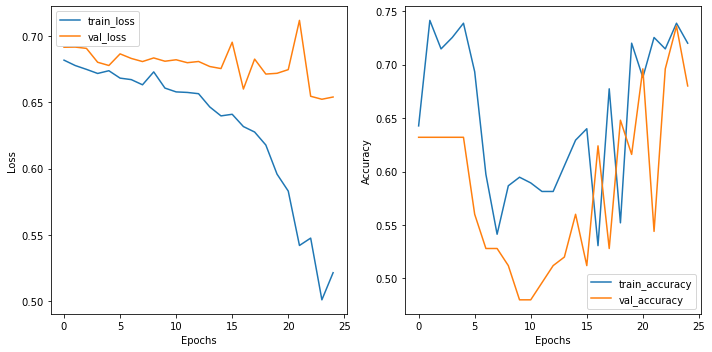

In [188]:
plot_metrics(model_18_results)

Let's go back to the original units, and add more dense layers in between to connect the neurons. 

# Model #19

In [189]:
model_19 = Sequential()

model_19.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_19.add(Dense(64, activation='relu')) # added
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.3))

model_19.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_19.add(Dense(64, activation='relu'))
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.2))

model_19.add(Conv2D(64, (3, 3), activation='relu'))
model_19.add(Dense(64, activation='relu'))
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.2))

model_19.add(Flatten())
model_19.add(Dense(64, activation='relu'))
model_19.add(Dense(32, activation='relu'))
model_19.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_19.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_98 (Dense)             (None, 62, 62, 64)        2112      
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_99 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 14, 14, 64)      

This added some of those lost parameters back in. Let's see how it does. 

In [190]:
model_19_results = model_19.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 239ms/step - loss: 0.6828 - accuracy: 0.5973 - precision: 0.7508 - recall: 0.7057 - val_loss: 0.6921 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 3s 336ms/step - loss: 0.6874 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6938 - val_accuracy: 0.6240 - val_precision: 0.6356 - val_recall: 0.9494
Epoch 3/25
8/8 [==============================] - 4s 542ms/step - loss: 0.6776 - accuracy: 0.6107 - precision: 0.7472 - recall: 0.7148 - val_loss: 0.6947 - val_accuracy: 0.6240 - val_precision: 0.6538 - val_recall: 0.8608
Epoch 4/25
8/8 [==============================] - 4s 544ms/step - loss: 0.6745 - accuracy: 0.7147 - precision: 0.7545 - recall: 0.9097 - val_loss: 0.6828 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 4s 513ms/step - loss: 0.6712 - accuracy: 0.7253 - precision: 0

In [191]:
evaluate_model(model_19)

4/4 [==============================] - 0s 47ms/step - loss: 0.5970 - accuracy: 0.7400 - precision: 0.8615 - recall: 0.7671
---------------------------
Training Loss: 0.415
Training Accuracy: 0.852
Training Precision: 0.875
Training Recall: 0.924
---------------------------
Testing Loss: 0.597
Testing Accuracy: 0.74
Testing Precision: 0.862
Testing Recall: 0.767


A little bit better! Still overfit, but the scores are all pretty good. 

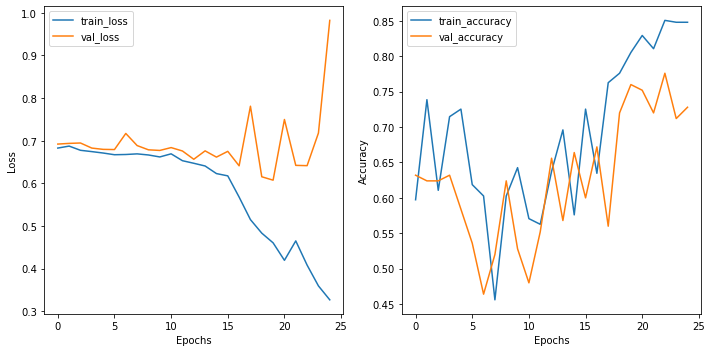

In [192]:
plot_metrics(model_19_results)

The loss and accuracy is still jumping around so much. I'd like to try and add some batch normalization in again.

# Model #20

Going back to model 12 as that was decent results. Adding in batch normalization to try and stablize loss/accuracy.

In [197]:
model_20 = Sequential()

model_20.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_20.add(Dense(64, activation='relu'))
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.3))

model_20.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_20.add(Dense(64, activation='relu'))
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.2))

model_20.add(Conv2D(64, (3, 3), activation='relu'))
model_20.add(BatchNormalization()) # added
model_20.add(Dense(64, activation='relu'))
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.2))

model_20.add(Flatten())
model_20.add(Dense(64, activation='relu'))
model_20.add(Dense(32, activation='relu'))
model_20.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_20.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_20.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_110 (Dense)            (None, 62, 62, 64)        2112      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_111 (Dense)            (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 14, 14, 64)      

That increased the parameters a little bit, let's see how it does. 

In [198]:
model_20_results = model_20.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 390ms/step - loss: 0.8069 - accuracy: 0.4613 - precision: 0.7184 - recall: 0.5686 - val_loss: 0.7021 - val_accuracy: 0.3680 - val_precision: 0.5000 - val_recall: 0.0253
Epoch 2/25
8/8 [==============================] - 4s 517ms/step - loss: 0.6856 - accuracy: 0.4613 - precision: 0.7389 - recall: 0.4188 - val_loss: 0.7006 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 4s 463ms/step - loss: 0.6785 - accuracy: 0.7093 - precision: 0.7333 - recall: 0.9531 - val_loss: 0.6997 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 4s 457ms/step - loss: 0.6768 - accuracy: 0.5173 - precision: 0.7609 - recall: 0.5054 - val_loss: 0.7000 - val_accuracy: 0.6400 - val_precision: 0.6371 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 3s 433ms/step - loss: 0.6725 - accuracy: 0.6400 - precision: 0

In [199]:
evaluate_model(model_20)

4/4 [==============================] - 0s 53ms/step - loss: 0.6053 - accuracy: 0.7300 - precision: 0.9259 - recall: 0.6849
---------------------------
Training Loss: 0.524
Training Accuracy: 0.864
Training Precision: 0.934
Training Recall: 0.871
---------------------------
Testing Loss: 0.605
Testing Accuracy: 0.73
Testing Precision: 0.926
Testing Recall: 0.685


Scores are about the same as the last model, let's check out the loss and accuracy. 

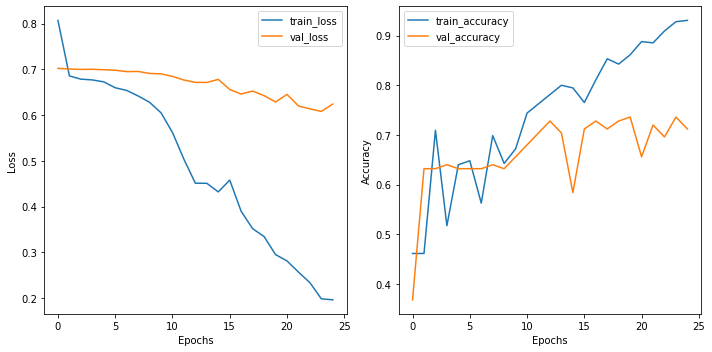

In [200]:
plot_metrics(model_20_results)

This seemed to stabilize the results a little bit. However, it seems like precision is higher than recall now. Let's adjust regularization again to address the overfitting. 

# Model #21

increasing regularization, added in another batch normalization. 

In [201]:
model_21 = Sequential()

model_21.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.3))

model_21.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_21.add(BatchNormalization())
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.3))

model_21.add(Conv2D(64, (3, 3), activation='relu'))
model_21.add(BatchNormalization())
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.2))

model_21.add(Flatten())
model_21.add(Dense(128, activation='relu'))
model_21.add(Dense(64, activation='relu'))
model_21.add(Dense(32, activation='relu'))
model_21.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_21.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_21.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 29, 29, 128)       36992     
_________________________________________________________________
batch_normalization_20 (Batc (None, 29, 29, 128)       512       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 14, 14, 128)     

In [202]:
model_21_results = model_21.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 213ms/step - loss: 0.7999 - accuracy: 0.5680 - precision: 0.7674 - recall: 0.6600 - val_loss: 0.6975 - val_accuracy: 0.5840 - val_precision: 0.6337 - val_recall: 0.8101
Epoch 2/25
8/8 [==============================] - 1s 160ms/step - loss: 0.6684 - accuracy: 0.4773 - precision: 0.7914 - recall: 0.3971 - val_loss: 0.6921 - val_accuracy: 0.6080 - val_precision: 0.6271 - val_recall: 0.9367
Epoch 3/25
8/8 [==============================] - 1s 152ms/step - loss: 0.6357 - accuracy: 0.6667 - precision: 0.8115 - recall: 0.7148 - val_loss: 0.6788 - val_accuracy: 0.6320 - val_precision: 0.6341 - val_recall: 0.9873
Epoch 4/25
8/8 [==============================] - 1s 152ms/step - loss: 0.5840 - accuracy: 0.6587 - precision: 0.8860 - recall: 0.6173 - val_loss: 0.6668 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 1s 153ms/step - loss: 0.5396 - accuracy: 0.7120 - precision: 0

In [203]:
evaluate_model(model_21)

4/4 [==============================] - 0s 36ms/step - loss: 2.4170 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
---------------------------
Training Loss: 2.66
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 2.42
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


Typical results. 

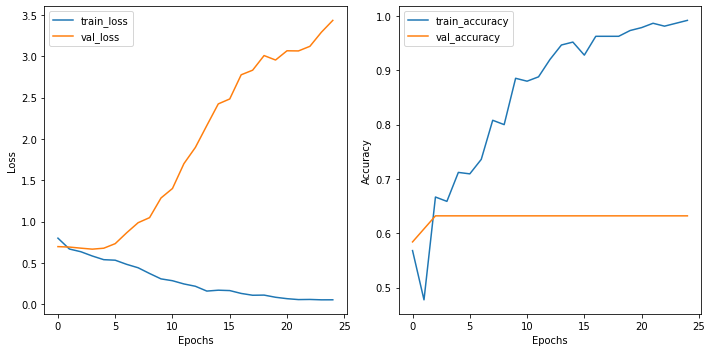

In [204]:
plot_metrics(model_21_results)

# Model #22

I realized my best model was using tanh: Let's try some of the other successful models using tanh and see what the results are. 

Model #17 had great training scores, but was a little overfit. Let's see if tanh helps it. 

In [205]:
model_22 = Sequential()

model_22.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_22.add(MaxPooling2D(pool_size=(2,2)))
model_22.add(Dropout(0.3))

model_22.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_22.add(MaxPooling2D(pool_size=(2,2)))
model_22.add(Dropout(0.3))

model_22.add(Conv2D(128, (3, 3), activation='tanh'))
model_22.add(MaxPooling2D(pool_size=(2,2)))
model_22.add(Dropout(0.2))

model_22.add(Flatten())
model_22.add(Dense(128, activation='tanh'))
model_22.add(Dense(64, activation='tanh'))
model_22.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_22.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_22.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 12, 12, 128)     

In [206]:
model_22_results = model_22.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 360ms/step - loss: 0.7057 - accuracy: 0.5440 - precision: 0.7317 - recall: 0.6857 - val_loss: 0.6916 - val_accuracy: 0.5760 - val_precision: 0.6667 - val_recall: 0.6582
Epoch 2/25
8/8 [==============================] - 2s 300ms/step - loss: 0.6766 - accuracy: 0.6160 - precision: 0.7737 - recall: 0.6787 - val_loss: 0.8212 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 2s 294ms/step - loss: 0.6802 - accuracy: 0.5600 - precision: 0.7772 - recall: 0.5668 - val_loss: 0.7113 - val_accuracy: 0.5040 - val_precision: 0.7576 - val_recall: 0.3165
Epoch 4/25
8/8 [==============================] - 2s 293ms/step - loss: 0.6733 - accuracy: 0.5707 - precision: 0.7900 - recall: 0.5704 - val_loss: 0.6638 - val_accuracy: 0.6000 - val_precision: 0.6747 - val_recall: 0.7089
Epoch 5/25
8/8 [==============================] - 4s 485ms/step - loss: 0.6557 - accuracy: 0.6480 - prec

In [207]:
evaluate_model(model_22)

4/4 [==============================] - 0s 74ms/step - loss: 0.6654 - accuracy: 0.8200 - precision: 0.8395 - recall: 0.9315
---------------------------
Training Loss: 0.253
Training Accuracy: 0.934
Training Precision: 0.942
Training Recall: 0.966
---------------------------
Testing Loss: 0.665
Testing Accuracy: 0.82
Testing Precision: 0.84
Testing Recall: 0.932


That helped increase the testing scores a little bit! Let's play with this model and try to reduce the overfitting a little more. 

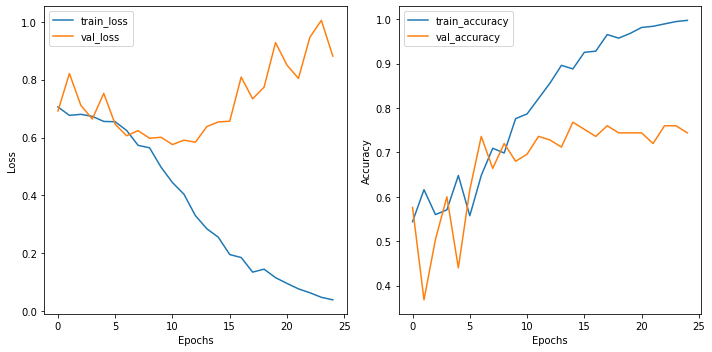

In [208]:
plot_metrics(model_22_results)

I note that the loss and accuracy are still struggling to converge. I noticed I didn't have batch normalization, let's add it at the end.

# Model #23

In [211]:
model_23 = Sequential()

model_23.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_23.add(MaxPooling2D(pool_size=(2,2)))
model_23.add(Dropout(0.3))

model_23.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_23.add(MaxPooling2D(pool_size=(2,2)))
model_23.add(Dropout(0.3))

model_23.add(Conv2D(128, (3, 3), activation='tanh'))
model_23.add(BatchNormalization()) # added
model_23.add(MaxPooling2D(pool_size=(2,2)))
model_23.add(Dropout(0.2))

model_23.add(Flatten())
model_23.add(Dense(128, activation='tanh'))
model_23.add(Dense(64, activation='tanh'))
model_23.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_23.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_23.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 12, 12, 128)     

This added a few more parameters. Let's see how it does. 

In [212]:
model_23_results = model_23.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 372ms/step - loss: 0.7949 - accuracy: 0.5387 - precision: 0.7770 - recall: 0.6371 - val_loss: 0.6544 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 2s 311ms/step - loss: 0.7192 - accuracy: 0.6160 - precision: 0.7270 - recall: 0.7690 - val_loss: 0.6617 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 3s 317ms/step - loss: 0.6697 - accuracy: 0.4853 - precision: 0.7958 - recall: 0.4079 - val_loss: 0.6701 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 3s 354ms/step - loss: 0.6423 - accuracy: 0.7173 - precision: 0.7647 - recall: 0.8917 - val_loss: 0.6729 - val_accuracy: 0.6320 - val_precision: 0.6460 - val_recall: 0.9241
Epoch 5/25
8/8 [==============================] - 5s 574ms/step - loss: 0.6339 - accuracy: 0.6133 - precision: 0

In [213]:
evaluate_model(model_23)

4/4 [==============================] - 0s 73ms/step - loss: 0.6432 - accuracy: 0.7000 - precision: 0.7263 - recall: 0.9452
---------------------------
Training Loss: 0.662
Training Accuracy: 0.746
Training Precision: 0.754
Training Recall: 0.955
---------------------------
Testing Loss: 0.643
Testing Accuracy: 0.7
Testing Precision: 0.726
Testing Recall: 0.945


I should have expected this - scores are lower all around! Loss and accuracy are a little less jagged, but not significantly so. 

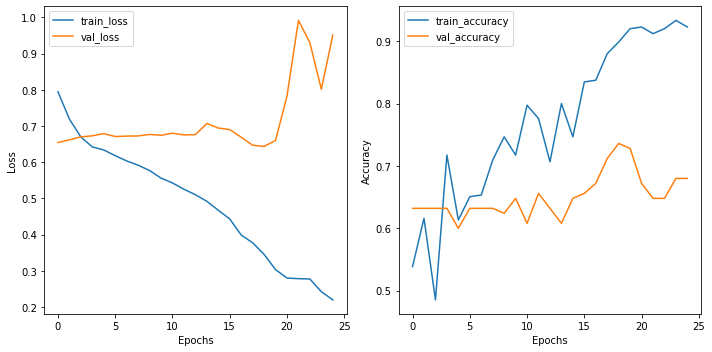

In [214]:
plot_metrics(model_23_results)

# Model #24

Let's remove the batch normalization, and add some L2 regularization at a low strength to address the overfitting instead. 

In [215]:
model_24 = Sequential()

model_24.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_24.add(MaxPooling2D(pool_size=(2,2)))
model_24.add(Dropout(0.3))

model_24.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.00001)))
model_24.add(MaxPooling2D(pool_size=(2,2)))
model_24.add(Dropout(0.3))

model_24.add(Conv2D(128, (3, 3), activation='tanh', kernel_regularizer=l2(0.00001)))
model_24.add(MaxPooling2D(pool_size=(2,2)))
model_24.add(Dropout(0.2))

model_24.add(Flatten())
model_24.add(Dense(128, activation='tanh'))
model_24.add(Dense(64, activation='tanh'))
model_24.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_24.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_24.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 12, 12, 128)     

In [216]:
model_24_results = model_24.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 353ms/step - loss: 0.7285 - accuracy: 0.5573 - precision: 0.7437 - recall: 0.6714 - val_loss: 0.6552 - val_accuracy: 0.6240 - val_precision: 0.6290 - val_recall: 0.9873
Epoch 2/25
8/8 [==============================] - 2s 307ms/step - loss: 0.6906 - accuracy: 0.5733 - precision: 0.7489 - recall: 0.6354 - val_loss: 0.7283 - val_accuracy: 0.4400 - val_precision: 0.6957 - val_recall: 0.2025
Epoch 3/25
8/8 [==============================] - 2s 304ms/step - loss: 0.6755 - accuracy: 0.6053 - precision: 0.7510 - recall: 0.6968 - val_loss: 0.6962 - val_accuracy: 0.4640 - val_precision: 0.7000 - val_recall: 0.2658
Epoch 4/25
8/8 [==============================] - 2s 296ms/step - loss: 0.6750 - accuracy: 0.4453 - precision: 0.8053 - recall: 0.3285 - val_loss: 0.6559 - val_accuracy: 0.7040 - val_precision: 0.7500 - val_recall: 0.7975
Epoch 5/25
8/8 [==============================] - 4s 483ms/step - loss: 0.6418 - accuracy: 0.7173 - precision: 0

In [217]:
evaluate_model(model_24)

4/4 [==============================] - 0s 71ms/step - loss: 1.1487 - accuracy: 0.7800 - precision: 0.7865 - recall: 0.9589
---------------------------
Training Loss: 0.383
Training Accuracy: 0.91
Training Precision: 0.902
Training Recall: 0.98
---------------------------
Testing Loss: 1.15
Testing Accuracy: 0.78
Testing Precision: 0.787
Testing Recall: 0.959


About the same as model #17. Let's try adjusting dropout instead. 

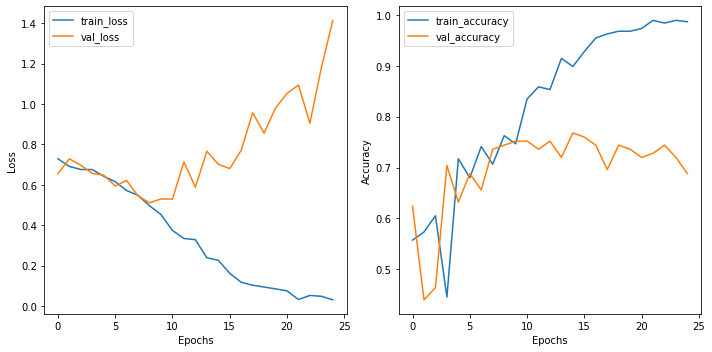

In [218]:
plot_metrics(model_24_results)

# Model #25

In [226]:
model_25 = Sequential()

model_25.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_25.add(MaxPooling2D(pool_size=(2,2)))
model_25.add(Dropout(0.3))

model_25.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_25.add(MaxPooling2D(pool_size=(2,2)))
model_25.add(Dropout(0.4)) # increased

model_25.add(Conv2D(128, (3, 3), activation='tanh'))
model_25.add(MaxPooling2D(pool_size=(2,2)))
model_25.add(Dropout(0.3)) # increased

model_25.add(Flatten())
model_25.add(Dense(128, activation='tanh'))
model_25.add(Dense(64, activation='tanh'))
model_25.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_25.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_25.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 12, 12, 128)     

In [227]:
model_25_results = model_25.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 365ms/step - loss: 0.7529 - accuracy: 0.5440 - precision: 0.7460 - recall: 0.6714 - val_loss: 0.6535 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 2s 293ms/step - loss: 0.6935 - accuracy: 0.6027 - precision: 0.7388 - recall: 0.7148 - val_loss: 0.6574 - val_accuracy: 0.6880 - val_precision: 0.6961 - val_recall: 0.8987
Epoch 3/25
8/8 [==============================] - 2s 299ms/step - loss: 0.6689 - accuracy: 0.4693 - precision: 0.8482 - recall: 0.3430 - val_loss: 0.6557 - val_accuracy: 0.6480 - val_precision: 0.6577 - val_recall: 0.9241
Epoch 4/25
8/8 [==============================] - 4s 465ms/step - loss: 0.6517 - accuracy: 0.6987 - precision: 0.7752 - recall: 0.8339 - val_loss: 0.6460 - val_accuracy: 0.6480 - val_precision: 0.7273 - val_recall: 0.7089
Epoch 5/25
8/8 [==============================] - 4s 476ms/step - loss: 0.6530 - accuracy: 0.5173 - precision: 0

In [228]:
evaluate_model(model_25)

4/4 [==============================] - 0s 79ms/step - loss: 0.8110 - accuracy: 0.7500 - precision: 0.8333 - recall: 0.8219
---------------------------
Training Loss: 0.351
Training Accuracy: 0.918
Training Precision: 0.903
Training Recall: 0.992
---------------------------
Testing Loss: 0.811
Testing Accuracy: 0.75
Testing Precision: 0.833
Testing Recall: 0.822


A little worse than the last model for the testing scores. Let's try adjusting the learning rate. 

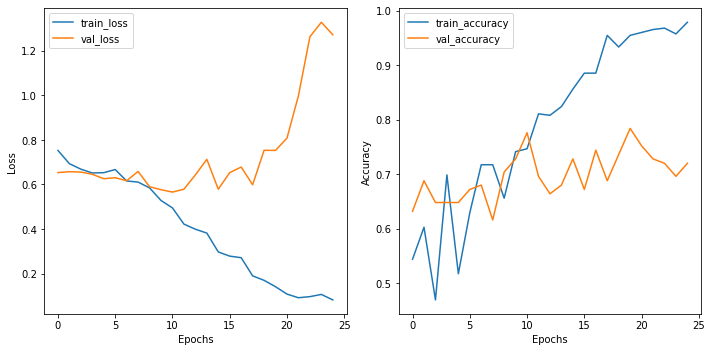

In [229]:
plot_metrics(model_25_results)

# Model #26

Starting with model #22 as a base. Then, we'll adjust the learning rate. 

In [230]:
model_26 = Sequential()

model_26.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_26.add(MaxPooling2D(pool_size=(2,2)))
model_26.add(Dropout(0.3))

model_26.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_26.add(MaxPooling2D(pool_size=(2,2)))
model_26.add(Dropout(0.3))

model_26.add(Conv2D(128, (3, 3), activation='tanh'))
model_26.add(MaxPooling2D(pool_size=(2,2)))
model_26.add(Dropout(0.2))

model_26.add(Flatten())
model_26.add(Dense(128, activation='tanh'))
model_26.add(Dense(64, activation='tanh'))
model_26.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_26.compile(optimizer=Adam(0.00001), loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_26.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 12, 12, 128)     

In [231]:
model_26_results = model_26.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 360ms/step - loss: 0.6884 - accuracy: 0.4453 - precision: 0.7600 - recall: 0.4886 - val_loss: 0.7034 - val_accuracy: 0.4800 - val_precision: 0.5897 - val_recall: 0.5823
Epoch 2/25
8/8 [==============================] - 2s 309ms/step - loss: 0.6839 - accuracy: 0.6107 - precision: 0.7510 - recall: 0.7076 - val_loss: 0.6966 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 3s 314ms/step - loss: 0.6859 - accuracy: 0.6907 - precision: 0.7403 - recall: 0.8953 - val_loss: 0.6926 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 3s 352ms/step - loss: 0.6782 - accuracy: 0.7360 - precision: 0.7486 - recall: 0.9675 - val_loss: 0.6911 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 4s 505ms/step - loss: 0.6801 - accuracy: 0.7253 - precision: 0

In [232]:
evaluate_model(model_26)

4/4 [==============================] - 0s 61ms/step - loss: 0.6854 - accuracy: 0.6400 - precision: 0.8776 - recall: 0.5890
---------------------------
Training Loss: 0.668
Training Accuracy: 0.688
Training Precision: 0.75
Training Recall: 0.843
---------------------------
Testing Loss: 0.685
Testing Accuracy: 0.64
Testing Precision: 0.878
Testing Recall: 0.589


That decreased the variance between training and testing accuracy, but also decreased the scores overall. Let's try a higher learning rate and see how it does. 

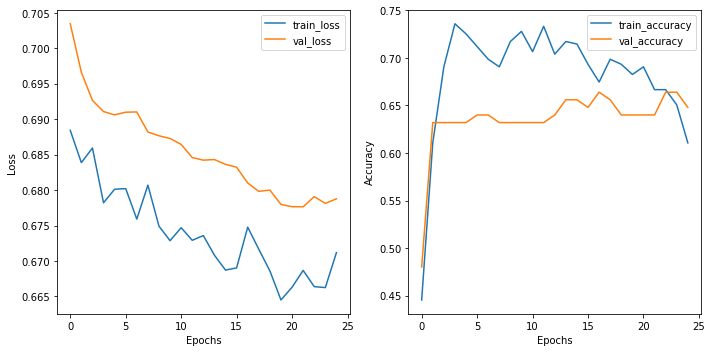

In [233]:
plot_metrics(model_26_results)

I will note that the curves do look a little more stable. They're still jumping around but they're going in the general right direction. 

Since I'm not changing anything but the learning rate, I will use the same model as above, but instead of a learning rate of 0.00001, I will use 0.0000000001. 

In [244]:
model_26 = Sequential()

model_26.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_26.add(MaxPooling2D(pool_size=(2,2)))
model_26.add(Dropout(0.3))

model_26.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_26.add(MaxPooling2D(pool_size=(2,2)))
model_26.add(Dropout(0.3))

model_26.add(Conv2D(128, (3, 3), activation='tanh'))
model_26.add(MaxPooling2D(pool_size=(2,2)))
model_26.add(Dropout(0.2))

model_26.add(Flatten())
model_26.add(Dense(128, activation='tanh'))
model_26.add(Dense(64, activation='tanh'))
model_26.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_26.compile(optimizer=Adam(0.0000000001), loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_26.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_137 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_137 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_138 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 12, 12, 128)     

In [245]:
model_26_results = model_26.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 8s 941ms/step - loss: 0.6839 - accuracy: 0.7253 - precision: 0.7569 - recall: 0.9296 - val_loss: 0.6953 - val_accuracy: 0.6320 - val_precision: 0.6341 - val_recall: 0.9873
Epoch 2/25
8/8 [==============================] - 7s 845ms/step - loss: 0.6843 - accuracy: 0.6987 - precision: 0.7343 - recall: 0.9278 - val_loss: 0.6953 - val_accuracy: 0.6320 - val_precision: 0.6341 - val_recall: 0.9873
Epoch 3/25
8/8 [==============================] - 6s 799ms/step - loss: 0.6858 - accuracy: 0.7067 - precision: 0.7339 - recall: 0.9458 - val_loss: 0.6953 - val_accuracy: 0.6320 - val_precision: 0.6341 - val_recall: 0.9873
Epoch 4/25
8/8 [==============================] - 6s 763ms/step - loss: 0.6854 - accuracy: 0.7173 - precision: 0.7408 - recall: 0.9495 - val_loss: 0.6953 - val_accuracy: 0.6320 - val_precision: 0.6341 - val_recall: 0.9873
Epoch 5/25
8/8 [==============================] - 6s 776ms/step - loss: 0.6876 - accuracy: 0.7120 - precision: 0

In [246]:
evaluate_model(model_26)

4/4 [==============================] - 0s 67ms/step - loss: 0.6783 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
---------------------------
Training Loss: 0.688
Training Accuracy: 0.696
Training Precision: 0.709
Training Recall: 0.972
---------------------------
Testing Loss: 0.678
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


A little bit better, not by much. 

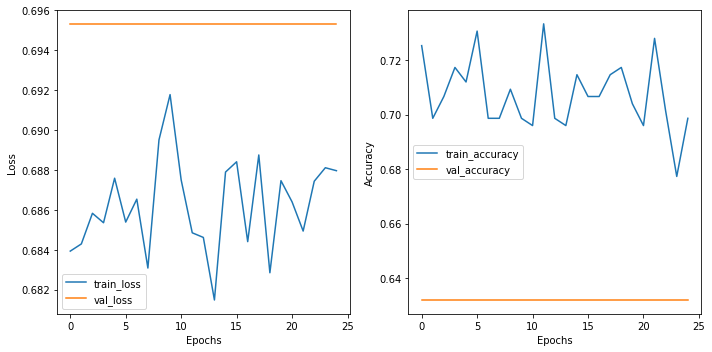

In [247]:
plot_metrics(model_26_results)

# Model #27

Let's try adding 1 more round of Conv2d, Maxpooling, and Dropout, and then another hidden dense layer. 

In [249]:
model_27 = Sequential()

model_27.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_27.add(MaxPooling2D(pool_size=(2,2)))
model_27.add(Dropout(0.3))

model_27.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_27.add(MaxPooling2D(pool_size=(2,2)))
model_27.add(Dropout(0.3))

model_27.add(Conv2D(128, (3, 3), activation='tanh'))
model_27.add(MaxPooling2D(pool_size=(2,2)))
model_27.add(Dropout(0.2))

# added
model_27.add(Conv2D(64, (3, 3), activation='tanh'))
model_27.add(MaxPooling2D(pool_size=(2,2)))
model_27.add(Dropout(0.2))

model_27.add(Flatten())
model_27.add(Dense(128, activation='tanh'))
model_27.add(Dense(64, activation='tanh'))
model_27.add(Dense(32, activation='tanh')) # added          
model_27.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_27.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_27.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 12, 12, 128)     

That decreased the parameters by about half. Let's see how it does. 

In [250]:
model_27_results = model_27.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 360ms/step - loss: 0.7077 - accuracy: 0.5093 - precision: 0.7340 - recall: 0.6229 - val_loss: 0.6642 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 2s 300ms/step - loss: 0.6848 - accuracy: 0.5600 - precision: 0.7569 - recall: 0.5957 - val_loss: 0.7090 - val_accuracy: 0.4640 - val_precision: 0.6364 - val_recall: 0.3544
Epoch 3/25
8/8 [==============================] - 2s 298ms/step - loss: 0.6744 - accuracy: 0.6107 - precision: 0.7472 - recall: 0.7148 - val_loss: 0.6864 - val_accuracy: 0.5680 - val_precision: 0.7273 - val_recall: 0.5063
Epoch 4/25
8/8 [==============================] - 2s 298ms/step - loss: 0.6723 - accuracy: 0.6347 - precision: 0.7756 - recall: 0.7112 - val_loss: 0.6690 - val_accuracy: 0.6240 - val_precision: 0.6818 - val_recall: 0.7595
Epoch 5/25
8/8 [==============================] - 3s 427ms/step - loss: 0.6532 - accuracy: 0.5333 - precision: 0

In [251]:
evaluate_model(model_27)

4/4 [==============================] - 0s 72ms/step - loss: 0.5659 - accuracy: 0.7700 - precision: 0.8571 - recall: 0.8219
---------------------------
Training Loss: 0.284
Training Accuracy: 0.908
Training Precision: 0.943
Training Recall: 0.927
---------------------------
Testing Loss: 0.566
Testing Accuracy: 0.77
Testing Precision: 0.857
Testing Recall: 0.822


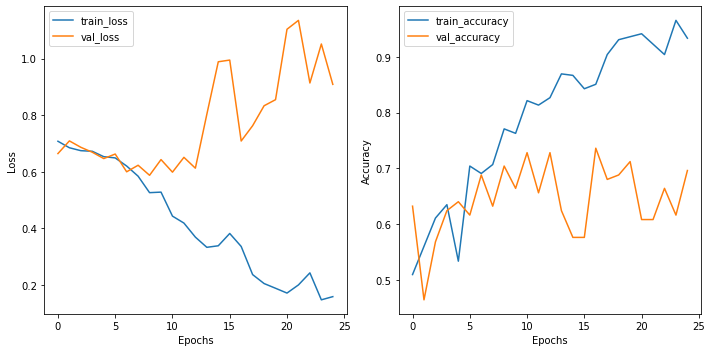

In [252]:
plot_metrics(model_27_results)

# Model #28

Let's strength the regularization. 

In [253]:
model_28 = Sequential()

model_28.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_28.add(MaxPooling2D(pool_size=(2,2)))
model_28.add(Dropout(0.3))

model_28.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_28.add(MaxPooling2D(pool_size=(2,2)))
model_28.add(Dropout(0.3))

model_28.add(Conv2D(128, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_28.add(MaxPooling2D(pool_size=(2,2)))
model_28.add(Dropout(0.2))

# added
model_28.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_28.add(MaxPooling2D(pool_size=(2,2)))
model_28.add(Dropout(0.2))

model_28.add(Flatten())
model_28.add(Dense(128, activation='tanh'))
model_28.add(Dense(64, activation='tanh'))
model_28.add(Dense(32, activation='tanh')) # added          
model_28.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_28.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_28.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_144 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_144 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 12, 12, 128)     

In [254]:
model_28_results = model_28.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 362ms/step - loss: 0.7813 - accuracy: 0.4853 - precision: 0.7538 - recall: 0.5686 - val_loss: 0.6813 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 3s 319ms/step - loss: 0.7227 - accuracy: 0.4880 - precision: 0.7485 - recall: 0.4621 - val_loss: 0.6773 - val_accuracy: 0.6240 - val_precision: 0.6333 - val_recall: 0.9620
Epoch 3/25
8/8 [==============================] - 3s 313ms/step - loss: 0.6985 - accuracy: 0.6933 - precision: 0.7736 - recall: 0.8267 - val_loss: 0.7211 - val_accuracy: 0.5120 - val_precision: 0.6800 - val_recall: 0.4304
Epoch 4/25
8/8 [==============================] - 3s 411ms/step - loss: 0.6940 - accuracy: 0.6000 - precision: 0.7926 - recall: 0.6209 - val_loss: 0.6758 - val_accuracy: 0.6400 - val_precision: 0.6735 - val_recall: 0.8354
Epoch 5/25
8/8 [==============================] - 4s 544ms/step - loss: 0.6938 - accuracy: 0.5493 - precision: 0

In [255]:
evaluate_model(model_28)

4/4 [==============================] - 0s 73ms/step - loss: 0.9668 - accuracy: 0.6800 - precision: 0.9362 - recall: 0.6027
---------------------------
Training Loss: 0.525
Training Accuracy: 0.846
Training Precision: 0.946
Training Recall: 0.831
---------------------------
Testing Loss: 0.967
Testing Accuracy: 0.68
Testing Precision: 0.936
Testing Recall: 0.603


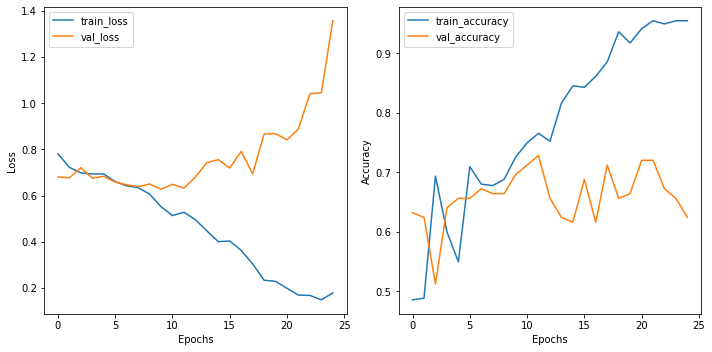

In [256]:
plot_metrics(model_28_results)

# Model #29

Let's remove some of the layers. Removed the added section a few models ago. 

In [257]:
model_29 = Sequential()

model_29.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_29.add(MaxPooling2D(pool_size=(2,2)))
model_29.add(Dropout(0.3))

model_29.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_29.add(MaxPooling2D(pool_size=(2,2)))
model_29.add(Dropout(0.3))

model_29.add(Conv2D(128, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_29.add(MaxPooling2D(pool_size=(2,2)))
model_29.add(Dropout(0.2))

model_29.add(Flatten())
model_29.add(Dense(128, activation='tanh'))
model_29.add(Dense(64, activation='tanh'))
model_29.add(Dense(32, activation='tanh')) # added          
model_29.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_29.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_29.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_148 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_149 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 12, 12, 128)     

In [261]:
model_29_results = model_29.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 337ms/step - loss: 0.0403 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1797 - val_accuracy: 0.7280 - val_precision: 0.7273 - val_recall: 0.9114
Epoch 2/25
8/8 [==============================] - 4s 534ms/step - loss: 0.0403 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1748 - val_accuracy: 0.7520 - val_precision: 0.7400 - val_recall: 0.9367
Epoch 3/25
8/8 [==============================] - 7s 935ms/step - loss: 0.0398 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.2959 - val_accuracy: 0.7440 - val_precision: 0.7238 - val_recall: 0.9620
Epoch 4/25
8/8 [==============================] - 7s 824ms/step - loss: 0.0387 - accuracy: 0.9973 - precision: 1.0000 - recall: 0.9964 - val_loss: 1.3013 - val_accuracy: 0.7200 - val_precision: 0.7115 - val_recall: 0.9367
Epoch 5/25
8/8 [==============================] - 6s 761ms/step - loss: 0.0378 - accuracy: 1.0000 - precision: 1

In [262]:
evaluate_model(model_29)

4/4 [==============================] - 0s 71ms/step - loss: 1.1036 - accuracy: 0.7000 - precision: 0.8525 - recall: 0.7123
---------------------------
Training Loss: 0.335
Training Accuracy: 0.936
Training Precision: 0.935
Training Recall: 0.978
---------------------------
Testing Loss: 1.1
Testing Accuracy: 0.7
Testing Precision: 0.852
Testing Recall: 0.712


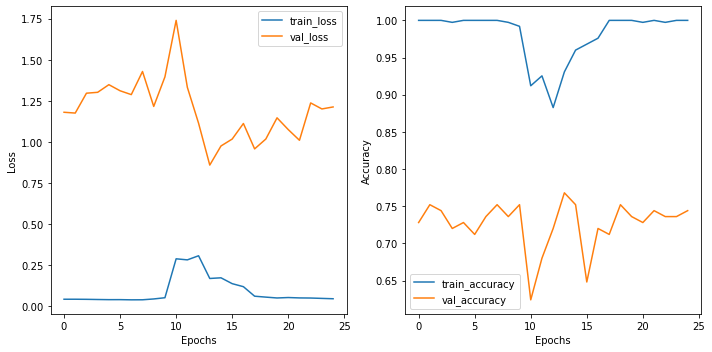

In [263]:
plot_metrics(model_29_results)

# Model #30

Adjusted some of the dropout and learning rates.

In [301]:
model_30 = Sequential()

model_30.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.001)))
model_30.add(MaxPooling2D(pool_size=(2,2)))

model_30.add(Conv2D(128, (3, 3), activation='tanh'))
model_30.add(MaxPooling2D(pool_size=(2,2)))

model_30.add(Conv2D(64, (3, 3), activation='tanh'))
model_30.add(MaxPooling2D(pool_size=(2,2)))

model_30.add(Flatten())
model_30.add(Dense(256, activation='tanh'))
model_30.add(Dense(128, activation='tanh'))
model_30.add(Dense(64, activation='tanh'))
model_30.add(Dense(32, activation='tanh'))
model_30.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model_30.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_30.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_169 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_171 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_57 (Flatten)         (None, 2304)            

In [302]:
model_30_results = model_30.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 202ms/step - loss: 0.7214 - accuracy: 0.5493 - precision: 0.7534 - recall: 0.6286 - val_loss: 0.8808 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 1s 150ms/step - loss: 0.7222 - accuracy: 0.5227 - precision: 0.7450 - recall: 0.5379 - val_loss: 0.7445 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 1s 153ms/step - loss: 0.6965 - accuracy: 0.5813 - precision: 0.7256 - recall: 0.6968 - val_loss: 0.6821 - val_accuracy: 0.6640 - val_precision: 0.6581 - val_recall: 0.9747
Epoch 4/25
8/8 [==============================] - 1s 150ms/step - loss: 0.6721 - accuracy: 0.6533 - precision: 0.7928 - recall: 0.7184 - val_loss: 0.6586 - val_accuracy: 0.6640 - val_precision: 0.7229 - val_recall: 0.7595
Epoch 5/25
8/8 [==============================] - 1s 167ms/step - loss: 0.6476 - accuracy: 0.685

In [303]:
evaluate_model(model_30)

4/4 [==============================] - 0s 50ms/step - loss: 1.1198 - accuracy: 0.7100 - precision: 0.7973 - recall: 0.8082
---------------------------
Training Loss: 0.294
Training Accuracy: 0.92
Training Precision: 0.927
Training Recall: 0.963
---------------------------
Testing Loss: 1.12
Testing Accuracy: 0.71
Testing Precision: 0.797
Testing Recall: 0.808


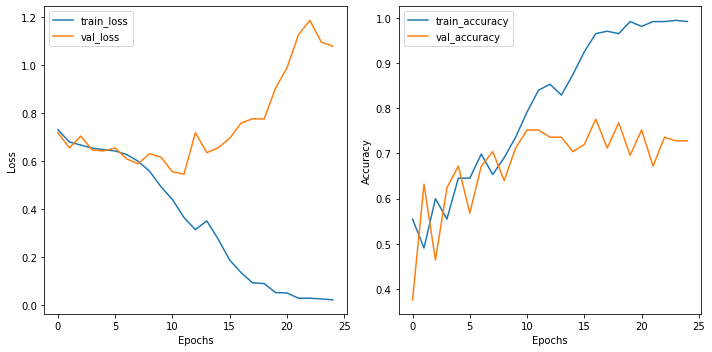

In [291]:
plot_metrics(model_30_results)

# Model #31

In [304]:
model_31 = Sequential()

model_31.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_31.add(Dense(64, activation='tanh'))
model_31.add(MaxPooling2D(pool_size=(2,2)))

model_31.add(Conv2D(128, (3, 3), activation='tanh'))
model_31.add(Dense(32, activation='tanh'))
model_31.add(MaxPooling2D(pool_size=(2,2)))

model_31.add(Conv2D(64, (3, 3), activation='tanh'))
model_31.add(MaxPooling2D(pool_size=(2,2)))

model_31.add(Flatten())
model_31.add(Dense(128, activation='tanh'))
model_31.add(Dense(64, activation='tanh'))
model_31.add(Dense(32, activation='tanh'))
model_31.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_31.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_31.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_172 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_198 (Dense)            (None, 62, 62, 64)        4160      
_________________________________________________________________
max_pooling2d_172 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_199 (Dense)            (None, 29, 29, 32)        4128      
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 12, 12, 64)      

In [305]:
model_31_results = model_31.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 224ms/step - loss: 0.7270 - accuracy: 0.6000 - precision: 0.7583 - recall: 0.7171 - val_loss: 0.7693 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 1s 183ms/step - loss: 0.6959 - accuracy: 0.5040 - precision: 0.7097 - recall: 0.5560 - val_loss: 0.6989 - val_accuracy: 0.4320 - val_precision: 1.0000 - val_recall: 0.1013
Epoch 3/25
8/8 [==============================] - 1s 179ms/step - loss: 0.6722 - accuracy: 0.3600 - precision: 0.8246 - recall: 0.1697 - val_loss: 0.6690 - val_accuracy: 0.6560 - val_precision: 0.6500 - val_recall: 0.9873
Epoch 4/25
8/8 [==============================] - 1s 180ms/step - loss: 0.6580 - accuracy: 0.7413 - precision: 0.7473 - recall: 0.9819 - val_loss: 0.6546 - val_accuracy: 0.6640 - val_precision: 0.6832 - val_recall: 0.8734
Epoch 5/25
8/8 [==============================] - 1s 176ms/step - loss: 0.6434 - accuracy: 0.5813 - prec

In [306]:
evaluate_model(model_31)

4/4 [==============================] - 0s 55ms/step - loss: 0.8350 - accuracy: 0.8400 - precision: 0.8608 - recall: 0.9315
---------------------------
Training Loss: 0.292
Training Accuracy: 0.936
Training Precision: 0.931
Training Recall: 0.983
---------------------------
Testing Loss: 0.835
Testing Accuracy: 0.84
Testing Precision: 0.861
Testing Recall: 0.932


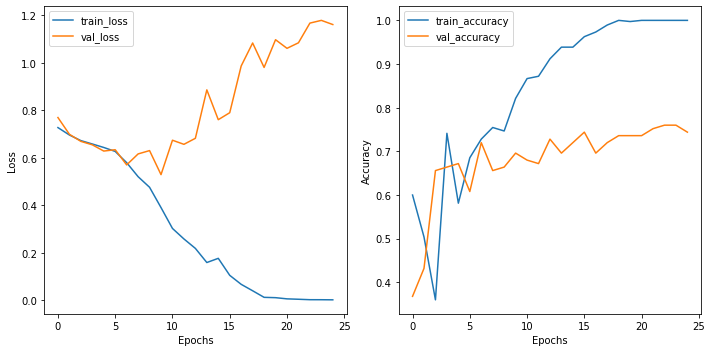

In [307]:
plot_metrics(model_31_results)

# Model #32

double units in new dense layers

In [312]:
model_32 = Sequential()

model_32.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_32.add(Dense(128, activation='tanh'))
model_32.add(MaxPooling2D(pool_size=(2,2)))

model_32.add(Conv2D(128, (3, 3), activation='tanh'))
model_32.add(Dense(64, activation='tanh'))
model_32.add(MaxPooling2D(pool_size=(2,2)))

model_32.add(Conv2D(64, (3, 3), activation='tanh'))
model_32.add(MaxPooling2D(pool_size=(2,2)))

model_32.add(Flatten())
model_32.add(Dense(128, activation='tanh'))
model_32.add(Dense(64, activation='tanh'))
model_32.add(Dense(32, activation='tanh'))
model_32.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_32.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_32.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_211 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_178 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_212 (Dense)            (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_179 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 12, 12, 64)      

In [313]:
model_32_results = model_32.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 8s 1s/step - loss: 0.7303 - accuracy: 0.5973 - precision: 0.7545 - recall: 0.7200 - val_loss: 0.7564 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 7s 855ms/step - loss: 0.6890 - accuracy: 0.5227 - precision: 0.7269 - recall: 0.5668 - val_loss: 0.7346 - val_accuracy: 0.4080 - val_precision: 0.6923 - val_recall: 0.1139
Epoch 3/25
8/8 [==============================] - 6s 749ms/step - loss: 0.6662 - accuracy: 0.5200 - precision: 0.7650 - recall: 0.5054 - val_loss: 0.6663 - val_accuracy: 0.5840 - val_precision: 0.6452 - val_recall: 0.7595
Epoch 4/25
8/8 [==============================] - 6s 733ms/step - loss: 0.6442 - accuracy: 0.6907 - precision: 0.7865 - recall: 0.7978 - val_loss: 0.6507 - val_accuracy: 0.6240 - val_precision: 0.7286 - val_recall: 0.6456
Epoch 5/25
8/8 [==============================] - 6s 727ms/step - loss: 0.6189 - accuracy: 0.6320 - precisi

In [314]:
evaluate_model(model_32)

4/4 [==============================] - 0s 81ms/step - loss: 1.1689 - accuracy: 0.7500 - precision: 0.7727 - recall: 0.9315
---------------------------
Training Loss: 0.33
Training Accuracy: 0.932
Training Precision: 0.926
Training Recall: 0.983
---------------------------
Testing Loss: 1.17
Testing Accuracy: 0.75
Testing Precision: 0.773
Testing Recall: 0.932


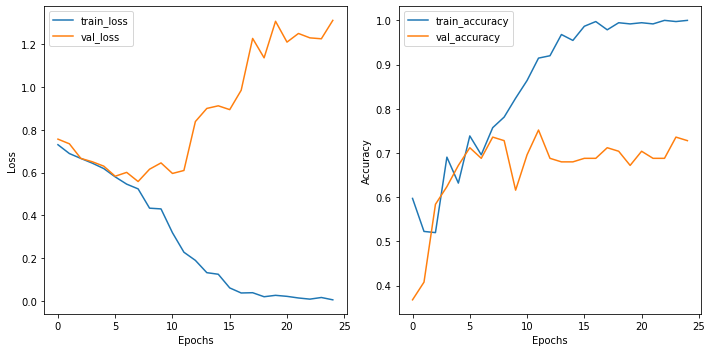

In [315]:
plot_metrics(model_32_results)

# Model #33

Let's use a mix of tanh and relu as the activation functions. 

In [316]:
model_33 = Sequential()

model_33.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_33.add(Dense(64, activation='tanh'))
model_33.add(MaxPooling2D(pool_size=(2,2)))

model_33.add(Conv2D(128, (3, 3), activation='relu'))
model_33.add(Dense(32, activation='relu'))
model_33.add(MaxPooling2D(pool_size=(2,2)))

model_33.add(Conv2D(64, (3, 3), activation='relu'))
model_33.add(MaxPooling2D(pool_size=(2,2)))

model_33.add(Flatten())
model_33.add(Dense(128, activation='relu'))
model_33.add(Dense(64, activation='tanh'))
model_33.add(Dense(32, activation='tanh'))
model_33.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_33.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_33.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_181 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_217 (Dense)            (None, 62, 62, 64)        4160      
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_218 (Dense)            (None, 29, 29, 32)        4128      
_________________________________________________________________
max_pooling2d_182 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 12, 12, 64)      

In [317]:
model_33_results = model_33.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 231ms/step - loss: 0.6821 - accuracy: 0.6427 - precision: 0.7507 - recall: 0.8171 - val_loss: 0.6914 - val_accuracy: 0.6000 - val_precision: 0.6593 - val_recall: 0.7595
Epoch 2/25
8/8 [==============================] - 1s 180ms/step - loss: 0.6718 - accuracy: 0.7467 - precision: 0.7542 - recall: 0.9747 - val_loss: 0.6800 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 1s 175ms/step - loss: 0.6654 - accuracy: 0.7253 - precision: 0.7544 - recall: 0.9314 - val_loss: 0.6541 - val_accuracy: 0.6400 - val_precision: 0.6393 - val_recall: 0.9873
Epoch 4/25
8/8 [==============================] - 1s 175ms/step - loss: 0.6597 - accuracy: 0.5760 - precision: 0.7706 - recall: 0.6065 - val_loss: 0.6562 - val_accuracy: 0.6640 - val_precision: 0.7284 - val_recall: 0.7468
Epoch 5/25
8/8 [==============================] - 1s 178ms/step - loss: 0.6497 - accuracy: 0.6827 - precision: 0

In [318]:
evaluate_model(model_33)

4/4 [==============================] - 0s 64ms/step - loss: 0.7967 - accuracy: 0.7700 - precision: 0.8378 - recall: 0.8493
---------------------------
Training Loss: 0.302
Training Accuracy: 0.928
Training Precision: 0.926
Training Recall: 0.978
---------------------------
Testing Loss: 0.797
Testing Accuracy: 0.77
Testing Precision: 0.838
Testing Recall: 0.849


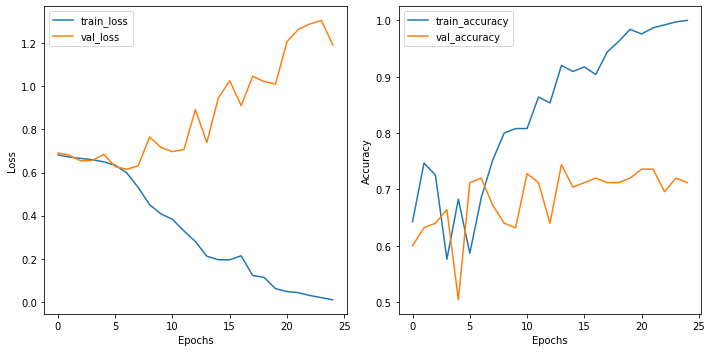

In [319]:
plot_metrics(model_33_results)

# Model #34

In [320]:
model_34 = Sequential()

model_34.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_34.add(Dense(64, activation='relu'))
model_34.add(MaxPooling2D(pool_size=(2,2)))

model_34.add(Conv2D(128, (3, 3), activation='relu'))
model_34.add(Dense(32, activation='relu'))
model_34.add(MaxPooling2D(pool_size=(2,2)))

model_34.add(Conv2D(64, (3, 3), activation='tanh'))
model_34.add(BatchNormalization())
model_34.add(MaxPooling2D(pool_size=(2,2)))

model_34.add(Flatten())
model_34.add(Dense(128, activation='tanh'))
model_34.add(Dense(64, activation='tanh'))
model_34.add(Dense(32, activation='tanh'))
model_34.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_34.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_223 (Dense)            (None, 62, 62, 64)        4160      
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_224 (Dense)            (None, 29, 29, 32)        4128      
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 12, 12, 64)      

In [321]:
model_34_results = model_34.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 214ms/step - loss: 0.7703 - accuracy: 0.4720 - precision: 0.7416 - recall: 0.5657 - val_loss: 0.6912 - val_accuracy: 0.6240 - val_precision: 0.6290 - val_recall: 0.9873
Epoch 2/25
8/8 [==============================] - 1s 169ms/step - loss: 0.6569 - accuracy: 0.6400 - precision: 0.7773 - recall: 0.7184 - val_loss: 0.6927 - val_accuracy: 0.4880 - val_precision: 0.6829 - val_recall: 0.3544
Epoch 3/25
8/8 [==============================] - 1s 172ms/step - loss: 0.6372 - accuracy: 0.5867 - precision: 0.7905 - recall: 0.5993 - val_loss: 0.6843 - val_accuracy: 0.6560 - val_precision: 0.6500 - val_recall: 0.9873
Epoch 4/25
8/8 [==============================] - 1s 173ms/step - loss: 0.5784 - accuracy: 0.7360 - precision: 0.8618 - recall: 0.7653 - val_loss: 0.6818 - val_accuracy: 0.6240 - val_precision: 0.7353 - val_recall: 0.6329
Epoch 5/25
8/8 [==============================] - 1s 181ms/step - loss: 0.5703 - accuracy: 0.7173 - precision: 0

In [322]:
evaluate_model(model_34)

4/4 [==============================] - 0s 58ms/step - loss: 0.6604 - accuracy: 0.7200 - precision: 0.9245 - recall: 0.6712
---------------------------
Training Loss: 0.614
Training Accuracy: 0.688
Training Precision: 0.967
Training Recall: 0.581
---------------------------
Testing Loss: 0.66
Testing Accuracy: 0.72
Testing Precision: 0.925
Testing Recall: 0.671


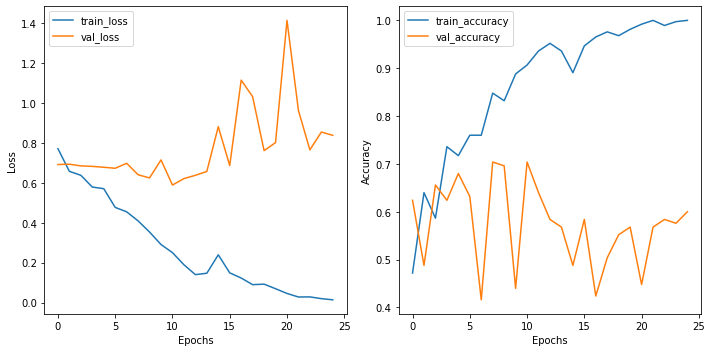

In [323]:
plot_metrics(model_34_results)

# Model #35

In [332]:
model_35 = Sequential()

model_35.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_35.add(Dense(128, activation='tanh'))
model_35.add(MaxPooling2D(pool_size=(2,2)))
model_35.add(Dropout(0.4))

model_35.add(Conv2D(256, (3, 3), activation='tanh'))
model_35.add(Dense(64, activation='tanh'))
model_35.add(MaxPooling2D(pool_size=(2,2)))
model_35.add(Dropout(0.3))

model_35.add(Conv2D(64, (3, 3), activation='tanh'))
model_35.add(MaxPooling2D(pool_size=(2,2)))
model_35.add(Dropout(0.2))

model_35.add(Flatten())
model_35.add(Dense(128, activation='tanh'))
model_35.add(Dense(64, activation='tanh'))
model_35.add(Dense(32, activation='tanh'))
model_35.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_35.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_35.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_193 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_241 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_193 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_242 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
max_pooling2d_194 (MaxPoolin (None, 14, 14, 64)      

In [333]:
model_35_results = model_35.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 4s 499ms/step - loss: 0.7119 - accuracy: 0.5067 - precision: 0.7796 - recall: 0.5457 - val_loss: 0.6587 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 6s 714ms/step - loss: 0.6722 - accuracy: 0.5440 - precision: 0.7345 - recall: 0.5993 - val_loss: 0.6667 - val_accuracy: 0.5200 - val_precision: 0.6203 - val_recall: 0.6203
Epoch 3/25
8/8 [==============================] - 6s 774ms/step - loss: 0.6576 - accuracy: 0.5280 - precision: 0.8086 - recall: 0.4729 - val_loss: 0.6421 - val_accuracy: 0.6400 - val_precision: 0.6809 - val_recall: 0.8101
Epoch 4/25
8/8 [==============================] - 6s 792ms/step - loss: 0.6422 - accuracy: 0.6027 - precision: 0.8019 - recall: 0.6137 - val_loss: 0.6281 - val_accuracy: 0.6320 - val_precision: 0.6813 - val_recall: 0.7848
Epoch 5/25
8/8 [==============================] - 7s 870ms/step - loss: 0.6304 - accuracy: 0.6827 - precision: 0

In [334]:
evaluate_model(model_35)

4/4 [==============================] - 0s 116ms/step - loss: 0.7534 - accuracy: 0.7000 - precision: 0.7792 - recall: 0.8219
---------------------------
Training Loss: 0.283
Training Accuracy: 0.916
Training Precision: 0.929
Training Recall: 0.955
---------------------------
Testing Loss: 0.753
Testing Accuracy: 0.7
Testing Precision: 0.779
Testing Recall: 0.822


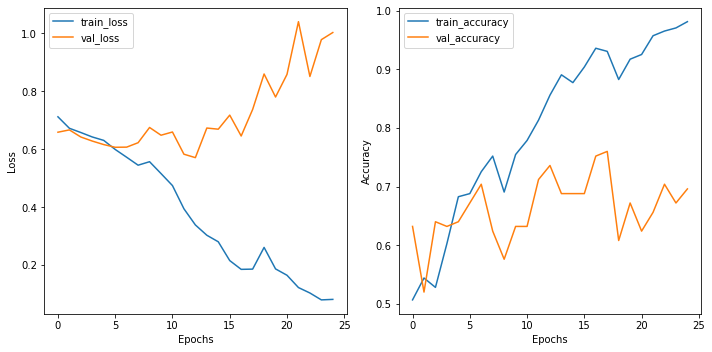

In [335]:
plot_metrics(model_35_results)

# Model #36

In [336]:
model_36 = Sequential()

model_36.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_36.add(Dense(128, activation='tanh'))
model_36.add(MaxPooling2D(pool_size=(2,2)))
model_36.add(Dropout(0.4))

model_36.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.000001)))
model_36.add(Dense(64, activation='tanh'))
model_36.add(MaxPooling2D(pool_size=(2,2)))
model_36.add(Dropout(0.3))

model_36.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.000001)))
model_36.add(MaxPooling2D(pool_size=(2,2)))
model_36.add(Dropout(0.2))

model_36.add(Flatten())
model_36.add(Dense(128, activation='tanh'))
model_36.add(Dense(64, activation='tanh'))
model_36.add(Dense(32, activation='tanh'))
model_36.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_36.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_36.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_196 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_247 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_196 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_89 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_248 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
max_pooling2d_197 (MaxPoolin (None, 14, 14, 64)      

In [337]:
model_36_results = model_36.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 4s 521ms/step - loss: 0.7808 - accuracy: 0.5413 - precision: 0.7662 - recall: 0.6086 - val_loss: 0.7838 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 4s 458ms/step - loss: 0.6908 - accuracy: 0.5093 - precision: 0.7514 - recall: 0.5018 - val_loss: 0.6640 - val_accuracy: 0.6400 - val_precision: 0.6417 - val_recall: 0.9747
Epoch 3/25
8/8 [==============================] - 6s 746ms/step - loss: 0.6750 - accuracy: 0.4880 - precision: 0.7322 - recall: 0.4838 - val_loss: 0.6632 - val_accuracy: 0.6720 - val_precision: 0.6939 - val_recall: 0.8608
Epoch 4/25
8/8 [==============================] - 7s 853ms/step - loss: 0.6606 - accuracy: 0.7200 - precision: 0.7515 - recall: 0.9278 - val_loss: 0.6701 - val_accuracy: 0.5360 - val_precision: 0.6842 - val_recall: 0.4937
Epoch 5/25
8/8 [==============================] - 7s 878ms/step - loss: 0.6537 - accuracy: 0.6187 - prec

In [338]:
evaluate_model(model_36)

4/4 [==============================] - 1s 128ms/step - loss: 0.6131 - accuracy: 0.8200 - precision: 0.8161 - recall: 0.9726
---------------------------
Training Loss: 0.252
Training Accuracy: 0.93
Training Precision: 0.917
Training Recall: 0.992
---------------------------
Testing Loss: 0.613
Testing Accuracy: 0.82
Testing Precision: 0.816
Testing Recall: 0.973


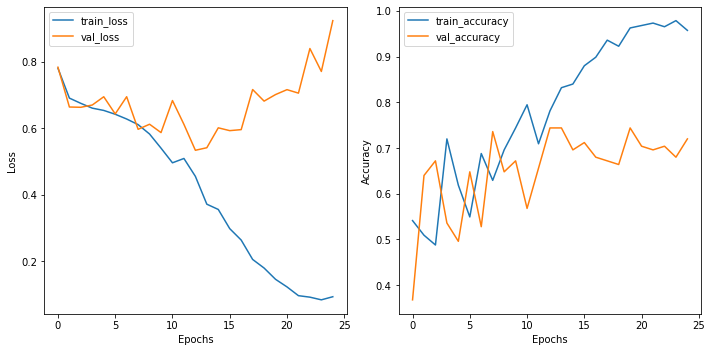

In [339]:
plot_metrics(model_36_results)

# Model #37

In [340]:
model_37 = Sequential()

model_37.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_37.add(Dense(128, activation='tanh'))
model_37.add(MaxPooling2D(pool_size=(2,2)))
model_37.add(Dropout(0.4))

model_37.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.000001)))
model_37.add(Dense(64, activation='tanh'))
model_37.add(MaxPooling2D(pool_size=(2,2)))
model_37.add(Dropout(0.3))

model_37.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.000001)))
model_37.add(MaxPooling2D(pool_size=(2,2)))
model_37.add(Dropout(0.2))

model_37.add(Flatten())
model_37.add(Dense(128, activation='tanh'))
model_37.add(Dropout(0.3))
model_37.add(Dense(64, activation='tanh'))
model_37.add(Dropout(0.2))
model_37.add(Dense(32, activation='tanh'))
model_37.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_37.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_37.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_199 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_253 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_199 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_254 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
max_pooling2d_200 (MaxPoolin (None, 14, 14, 64)      

In [341]:
model_37_results = model_37.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 7s 841ms/step - loss: 0.7287 - accuracy: 0.5627 - precision: 0.7561 - recall: 0.7086 - val_loss: 0.7033 - val_accuracy: 0.4960 - val_precision: 0.6481 - val_recall: 0.4430
Epoch 2/25
8/8 [==============================] - 4s 446ms/step - loss: 0.6754 - accuracy: 0.5760 - precision: 0.7634 - recall: 0.6173 - val_loss: 0.6825 - val_accuracy: 0.5520 - val_precision: 0.7347 - val_recall: 0.4557
Epoch 3/25
8/8 [==============================] - 6s 721ms/step - loss: 0.6719 - accuracy: 0.5547 - precision: 0.7412 - recall: 0.6101 - val_loss: 0.6816 - val_accuracy: 0.5440 - val_precision: 0.6833 - val_recall: 0.5190
Epoch 4/25
8/8 [==============================] - 6s 796ms/step - loss: 0.6483 - accuracy: 0.5467 - precision: 0.8023 - recall: 0.5126 - val_loss: 0.6427 - val_accuracy: 0.6480 - val_precision: 0.6733 - val_recall: 0.8608
Epoch 5/25
8/8 [==============================] - 7s 848ms/step - loss: 0.6401 - accuracy: 0.6267 - precision: 0

In [342]:
evaluate_model(model_37)

4/4 [==============================] - 1s 126ms/step - loss: 0.7514 - accuracy: 0.7700 - precision: 0.7907 - recall: 0.9315
---------------------------
Training Loss: 0.228
Training Accuracy: 0.934
Training Precision: 0.931
Training Recall: 0.98
---------------------------
Testing Loss: 0.751
Testing Accuracy: 0.77
Testing Precision: 0.791
Testing Recall: 0.932


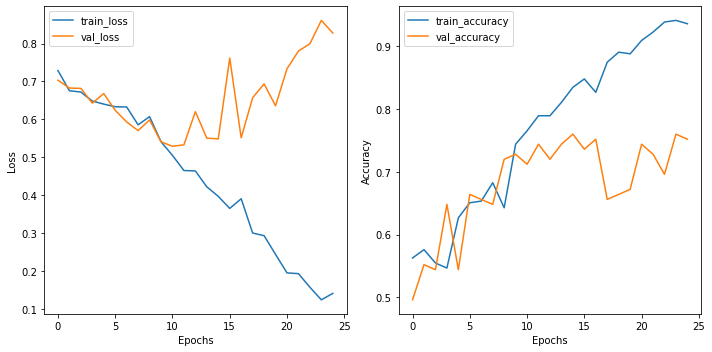

In [343]:
plot_metrics(model_37_results)

# Model #38

Increase regularization.

In [344]:
model_38 = Sequential()

model_38.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_38.add(Dense(128, activation='tanh'))
model_38.add(MaxPooling2D(pool_size=(2,2)))
model_38.add(Dropout(0.5))

model_38.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_38.add(Dense(64, activation='tanh'))
model_38.add(MaxPooling2D(pool_size=(2,2)))
model_38.add(Dropout(0.3))

model_38.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_38.add(MaxPooling2D(pool_size=(2,2)))
model_38.add(Dropout(0.2))

model_38.add(Flatten())
model_38.add(Dense(128, activation='tanh'))
model_38.add(Dropout(0.3))
model_38.add(Dense(64, activation='tanh'))
model_38.add(Dropout(0.2))
model_38.add(Dense(32, activation='tanh'))
model_38.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_38.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_38.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_202 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_259 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_202 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_260 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
max_pooling2d_203 (MaxPoolin (None, 14, 14, 64)      

In [345]:
model_38_results = model_38.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 4s 510ms/step - loss: 0.7573 - accuracy: 0.5653 - precision: 0.7547 - recall: 0.6943 - val_loss: 0.6752 - val_accuracy: 0.6320 - val_precision: 0.6387 - val_recall: 0.9620
Epoch 2/25
8/8 [==============================] - 4s 469ms/step - loss: 0.7235 - accuracy: 0.5413 - precision: 0.7638 - recall: 0.5487 - val_loss: 0.6836 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 5s 623ms/step - loss: 0.7057 - accuracy: 0.5413 - precision: 0.7488 - recall: 0.5704 - val_loss: 0.7099 - val_accuracy: 0.5360 - val_precision: 0.6364 - val_recall: 0.6203
Epoch 4/25
8/8 [==============================] - 6s 808ms/step - loss: 0.6935 - accuracy: 0.6427 - precision: 0.7527 - recall: 0.7690 - val_loss: 0.7186 - val_accuracy: 0.4880 - val_precision: 0.6667 - val_recall: 0.3797
Epoch 5/25
8/8 [==============================] - 6s 802ms/step - loss: 0.6824 - accuracy: 0.5467 - precision: 0

In [346]:
evaluate_model(model_38)

4/4 [==============================] - 0s 122ms/step - loss: 0.5647 - accuracy: 0.7500 - precision: 0.8636 - recall: 0.7808
---------------------------
Training Loss: 0.348
Training Accuracy: 0.866
Training Precision: 0.953
Training Recall: 0.854
---------------------------
Testing Loss: 0.565
Testing Accuracy: 0.75
Testing Precision: 0.864
Testing Recall: 0.781


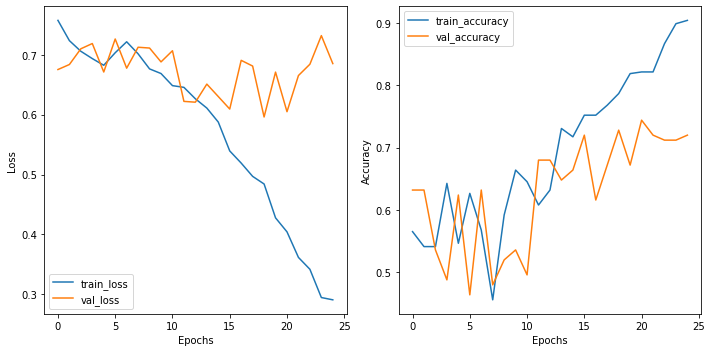

In [347]:
plot_metrics(model_38_results)

# Model #39

added batch norm after double activations

In [348]:
model_39 = Sequential()

model_39.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_39.add(Dense(128, activation='tanh'))
model_39.add(BatchNormalization())
model_39.add(MaxPooling2D(pool_size=(2,2)))
model_39.add(Dropout(0.5))

model_39.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_39.add(Dense(64, activation='tanh'))
model_39.add(BatchNormalization())
model_39.add(MaxPooling2D(pool_size=(2,2)))
model_39.add(Dropout(0.3))

model_39.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_39.add(MaxPooling2D(pool_size=(2,2)))
model_39.add(Dropout(0.2))

model_39.add(Flatten())
model_39.add(Dense(128, activation='tanh'))
model_39.add(Dropout(0.3))
model_39.add(Dense(64, activation='tanh'))
model_39.add(Dropout(0.2))
model_39.add(Dense(32, activation='tanh'))
model_39.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_39.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_39.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_205 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_265 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
batch_normalization_27 (Batc (None, 62, 62, 128)       512       
_________________________________________________________________
max_pooling2d_205 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_102 (Dropout)        (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_266 (Dense)            (None, 29, 29, 64)      

In [349]:
model_39_results = model_39.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 16s 2s/step - loss: 0.7243 - accuracy: 0.6160 - precision: 0.7701 - recall: 0.7371 - val_loss: 0.6728 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 13s 2s/step - loss: 0.7207 - accuracy: 0.4427 - precision: 0.7537 - recall: 0.3646 - val_loss: 0.6605 - val_accuracy: 0.6240 - val_precision: 0.6290 - val_recall: 0.9873
Epoch 3/25
8/8 [==============================] - 12s 2s/step - loss: 0.6994 - accuracy: 0.5787 - precision: 0.7598 - recall: 0.6282 - val_loss: 0.6770 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 12s 2s/step - loss: 0.7002 - accuracy: 0.5973 - precision: 0.7351 - recall: 0.7112 - val_loss: 0.6824 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 13s 2s/step - loss: 0.6888 - accuracy: 0.5333 - precision: 0.7833 - re

In [350]:
evaluate_model(model_39)

4/4 [==============================] - 1s 137ms/step - loss: 0.7441 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
---------------------------
Training Loss: 0.918
Training Accuracy: 0.714
Training Precision: 0.713
Training Recall: 1.0
---------------------------
Testing Loss: 0.744
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


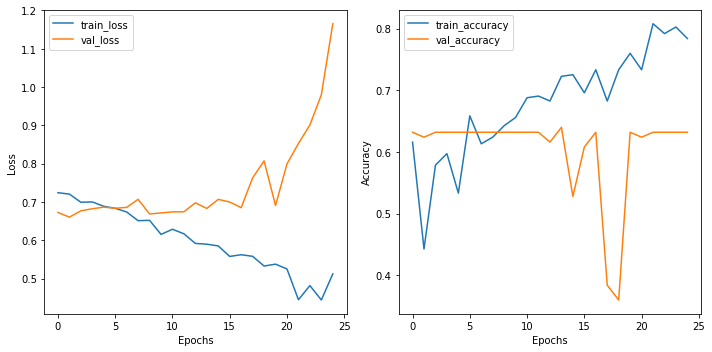

In [351]:
plot_metrics(model_39_results)

# Model #40

In [356]:
model_40 = Sequential()

model_40.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_40.add(Dense(128, activation='tanh'))
model_40.add(MaxPooling2D(pool_size=(2,2)))
model_40.add(Dropout(0.5))

model_40.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_40.add(Dense(64, activation='tanh'))
model_40.add(BatchNormalization())
model_40.add(MaxPooling2D(pool_size=(2,2)))
model_40.add(Dropout(0.3))

model_40.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_40.add(MaxPooling2D(pool_size=(2,2)))
model_40.add(Dropout(0.2))

model_40.add(Flatten())
model_40.add(Dense(128, activation='tanh'))
model_40.add(Dropout(0.3))
model_40.add(Dense(64, activation='tanh'))
model_40.add(Dropout(0.2))
model_40.add(Dense(32, activation='tanh'))
model_40.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_40.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_40.summary()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_211 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_277 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_211 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_278 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
batch_normalization_30 (Batc (None, 29, 29, 64)      

In [357]:
model_40_results = model_40.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 11s 1s/step - loss: 0.7363 - accuracy: 0.5600 - precision: 0.7293 - recall: 0.5543 - val_loss: 0.7122 - val_accuracy: 0.5600 - val_precision: 0.6935 - val_recall: 0.5443
Epoch 2/25
8/8 [==============================] - 9s 1s/step - loss: 0.7062 - accuracy: 0.5333 - precision: 0.7802 - recall: 0.5126 - val_loss: 0.6829 - val_accuracy: 0.5840 - val_precision: 0.6239 - val_recall: 0.8608
Epoch 3/25
8/8 [==============================] - 9s 1s/step - loss: 0.7032 - accuracy: 0.6853 - precision: 0.7477 - recall: 0.8664 - val_loss: 0.6797 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 9s 1s/step - loss: 0.7012 - accuracy: 0.6320 - precision: 0.7509 - recall: 0.7509 - val_loss: 0.6832 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 9s 1s/step - loss: 0.6970 - accuracy: 0.5627 - precision: 0.7580 - recall

In [358]:
evaluate_model(model_40)

4/4 [==============================] - 0s 123ms/step - loss: 0.5475 - accuracy: 0.7900 - precision: 0.7826 - recall: 0.9863
---------------------------
Training Loss: 0.509
Training Accuracy: 0.766
Training Precision: 0.791
Training Recall: 0.913
---------------------------
Testing Loss: 0.548
Testing Accuracy: 0.79
Testing Precision: 0.783
Testing Recall: 0.986


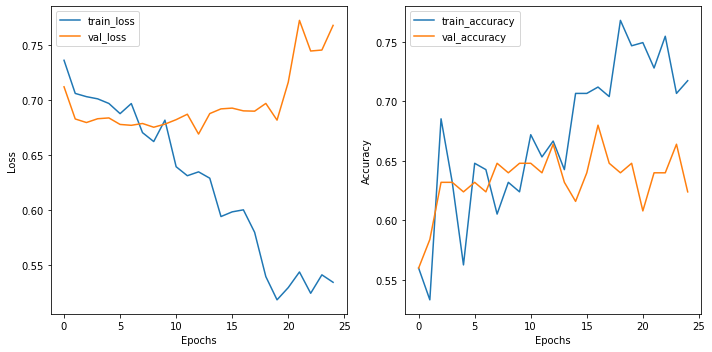

In [359]:
plot_metrics(model_40_results)

# Model #41

decrease some of the regularization

In [360]:
model_41 = Sequential()

model_41.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_41.add(Dense(128, activation='tanh'))
model_41.add(MaxPooling2D(pool_size=(2,2)))
model_41.add(Dropout(0.3))

model_41.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_41.add(Dense(64, activation='tanh'))
model_41.add(BatchNormalization())
model_41.add(MaxPooling2D(pool_size=(2,2)))
model_41.add(Dropout(0.3))

model_41.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_41.add(MaxPooling2D(pool_size=(2,2)))
model_41.add(Dropout(0.2))

model_41.add(Flatten())
model_41.add(Dense(128, activation='tanh'))
model_41.add(Dropout(0.2))
model_41.add(Dense(64, activation='tanh'))
model_41.add(Dropout(0.1))
model_41.add(Dense(32, activation='tanh'))
model_41.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_41.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_41.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_214 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_283 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_214 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_117 (Dropout)        (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_284 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
batch_normalization_31 (Batc (None, 29, 29, 64)      

In [361]:
model_41_results = model_41.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 4s 560ms/step - loss: 0.7357 - accuracy: 0.5307 - precision: 0.7325 - recall: 0.6886 - val_loss: 0.6969 - val_accuracy: 0.6000 - val_precision: 0.6283 - val_recall: 0.8987
Epoch 2/25
8/8 [==============================] - 4s 479ms/step - loss: 0.6867 - accuracy: 0.4987 - precision: 0.7633 - recall: 0.4657 - val_loss: 0.6851 - val_accuracy: 0.6240 - val_precision: 0.6311 - val_recall: 0.9747
Epoch 3/25
8/8 [==============================] - 6s 783ms/step - loss: 0.6923 - accuracy: 0.6907 - precision: 0.7524 - recall: 0.8664 - val_loss: 0.6812 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 6s 791ms/step - loss: 0.6743 - accuracy: 0.6587 - precision: 0.7790 - recall: 0.7509 - val_loss: 0.6830 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 7s 909ms/step - loss: 0.6619 - accuracy: 0.6080 - precision: 0

In [362]:
evaluate_model(model_41)

4/4 [==============================] - 0s 118ms/step - loss: 0.6958 - accuracy: 0.7500 - precision: 0.8529 - recall: 0.7945
---------------------------
Training Loss: 0.555
Training Accuracy: 0.778
Training Precision: 0.81
Training Recall: 0.899
---------------------------
Testing Loss: 0.696
Testing Accuracy: 0.75
Testing Precision: 0.853
Testing Recall: 0.795


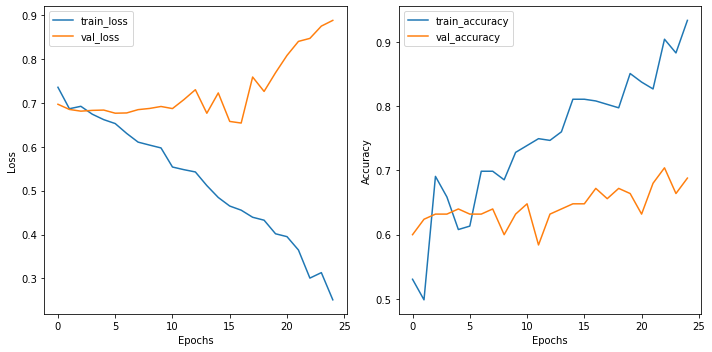

In [363]:
plot_metrics(model_41_results)

# Model #42

In [405]:
model_42 = Sequential()

model_42.add(Conv2D(filters=32, kernel_size=(3,3), 
                    activation='relu', 
                    input_shape=input_shape))
model_42.add(MaxPooling2D(pool_size=(2,2)))

model_42.add(Conv2D(128, (3, 3), activation='tanh'))
model_42.add(MaxPooling2D(pool_size=(2,2)))
model_42.add(Dropout(0.2))

model_42.add(Conv2D(64, (3, 3), activation='tanh'))
model_42.add(MaxPooling2D(pool_size=(2,2)))
model_42.add(Dropout(0.3))

model_42.add(Flatten())
model_42.add(Dense(32, activation='tanh'))
model_42.add(Dropout(0.4))
model_42.add(Dense(16, activation='tanh'))
model_42.add(Dropout(0.4))
model_42.add(Dense(1, activation='sigmoid'))

model_42.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', precision, recall])

model_42.summary()

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_245 (Conv2D)          (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_245 (MaxPoolin (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_246 (MaxPoolin (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_140 (Dropout)        (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_247 (Conv2D)          (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_247 (MaxPoolin (None, 6, 6, 64)        

In [406]:
model_42_results = model_42.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 1s 154ms/step - loss: 0.6810 - accuracy: 0.5947 - precision: 0.7823 - recall: 0.6571 - val_loss: 0.7092 - val_accuracy: 0.4320 - val_precision: 0.6429 - val_recall: 0.2278
Epoch 2/25
8/8 [==============================] - 1s 108ms/step - loss: 0.6788 - accuracy: 0.6293 - precision: 0.7634 - recall: 0.7220 - val_loss: 0.6753 - val_accuracy: 0.5520 - val_precision: 0.6420 - val_recall: 0.6582
Epoch 3/25
8/8 [==============================] - 1s 165ms/step - loss: 0.6550 - accuracy: 0.5760 - precision: 0.8242 - recall: 0.5415 - val_loss: 0.6757 - val_accuracy: 0.5520 - val_precision: 0.6716 - val_recall: 0.5696
Epoch 4/25
8/8 [==============================] - 2s 226ms/step - loss: 0.6715 - accuracy: 0.5600 - precision: 0.7617 - recall: 0.5884 - val_loss: 0.6652 - val_accuracy: 0.6880 - val_precision: 0.7083 - val_recall: 0.8608
Epoch 5/25
8/8 [==============================] - 2s 224ms/step - loss: 0.6694 - accuracy: 0.5493 - precision: 0

In [407]:
evaluate_model(model_42)

4/4 [==============================] - 0s 30ms/step - loss: 0.6418 - accuracy: 0.7200 - precision: 0.9091 - recall: 0.6849
---------------------------
Training Loss: 0.444
Training Accuracy: 0.774
Training Precision: 0.939
Training Recall: 0.73
---------------------------
Testing Loss: 0.642
Testing Accuracy: 0.72
Testing Precision: 0.909
Testing Recall: 0.685


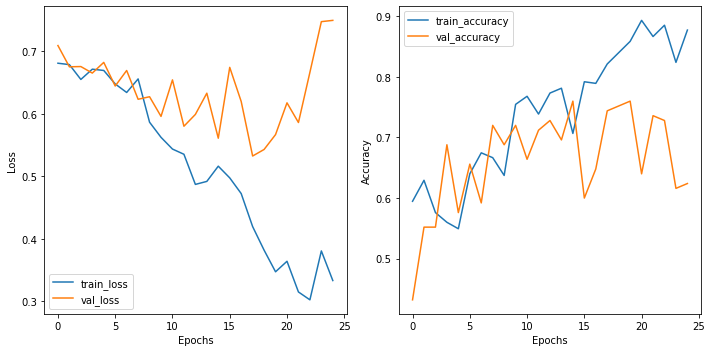

In [408]:
plot_metrics(model_42_results)

# Picking a Final Model

Model #12 performed the best on the testing set with the smallest variance to the training set. Using model #12 as the final model. 

In [412]:
final_model = model_2
final_model_results = model_2_results

In [413]:
evaluate_model(final_model)

4/4 [==============================] - 0s 8ms/step - loss: 0.4483 - accuracy: 0.7900 - precision: 0.8023 - recall: 0.9452
---------------------------
Training Loss: 0.447
Training Accuracy: 0.802
Training Precision: 0.79
Training Recall: 0.983
---------------------------
Testing Loss: 0.448
Testing Accuracy: 0.79
Testing Precision: 0.802
Testing Recall: 0.945


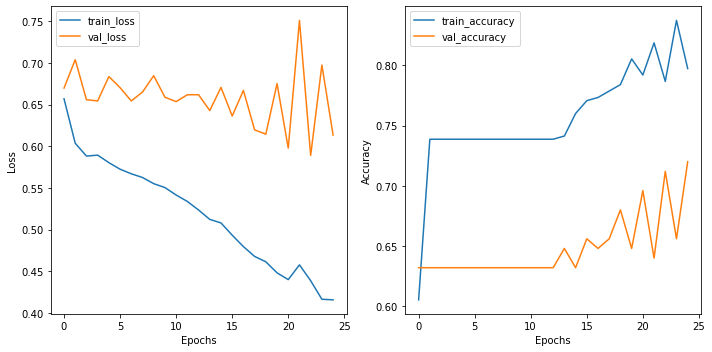

In [414]:
plot_metrics(final_model_results)

# Exploring the Predictions

Testing the final model on all data.

In [416]:
final_model.evaluate(train_images, binary_train_labels)

16/16 [==============================] - 0s 12ms/step - loss: 0.4474 - accuracy: 0.8020 - precision: 0.7901 - recall: 0.9831


[0.4473949670791626, 0.8019999861717224, 0.790067732334137, 0.983146071434021]

In [417]:
final_model.evaluate(test_images, binary_test_labels)

4/4 [==============================] - 0s 8ms/step - loss: 0.4483 - accuracy: 0.7900 - precision: 0.8023 - recall: 0.9452


[0.448314368724823, 0.7900000214576721, 0.8023256063461304, 0.9452054500579834]

In [418]:
final_model.evaluate(val_images, binary_val_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.7239 - accuracy: 0.6000 - precision: 0.6667 - recall: 0.6667


[0.7238874435424805,
 0.6000000238418579,
 0.6666666865348816,
 0.6666666865348816]

# Conclusion

# Next Steps